# Convolutional neural network

## Dependencies


In [15]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import time  # Import for measuring training time
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from typing import List
from torchinfo import summary
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from scipy.sparse import spmatrix
import seaborn as sns

# Get current notebook path
notebook_path = Path.cwd()
# Go up one level to reach project root
project_root = notebook_path.parent.parent
sys.path.insert(0, str(project_root))

from scripts.dataLoading import data_3cl, mat_snv_sg_3cl, mat_deriv1_3cl, mat_deriv2_3cl, spectral_cols
from src.data_augmenter import DataAugmenter, AugmentationParams


## Metrics & reusable functions

We define what will be our metrics, for both regression and classification task. We add the epoch_time, which will serve us to have an understandment of the "cost" of the learning. We factorise the plot and metrics across all projects

In [2]:
from src.metrics import (
    ClassificationMetrics,
    RegressionMetrics,
    plot_regression_metrics_sequence,
    print_regression_metrics,
    plot_classification_metrics_sequence,
    print_classification_metrics
)


## Global parameters


In [3]:
# ==============================================================================
# CONFIGURABLE PARAMETERS
# ==============================================================================
# Number of training epochs
N_EPOCHS = 150
# Random seed for reproducibility
RANDOM_SEED = 42
# Batch size for training
BATCH_SIZE = 32
# Learning rate for the optimizer
LEARNING_RATE = 0.00001
# Proportion of data for the test set
TEST_SIZE = 0.25
# Proportion of data for the validation set (relative to remaining data)
VAL_SIZE = 0.2
# Kernel size for convolutional layers
KERNEL_SIZE = 3
# Stride for convolutional layers
STRIDE = 1
# Padding for convolutional layers
PADDING = 2
# ==============================================================================


## Regression


In [4]:


# Custom Dataset class for our spectral data
class SpectralDataset(Dataset):
    """Dataset class to handle spectral data for PyTorch"""

    def __init__(self, X: np.ndarray | spmatrix, y: np.ndarray | spmatrix):
        # Reshape X for CNN input: [batch_size, channels, sequence_length]
        # For spectral data, we use 1 channel
        self.X = torch.FloatTensor(X).unsqueeze(1)  # Add channel dimension
        self.y = torch.FloatTensor(y)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.X[idx], self.y[idx]


### Without pretreatments


In [5]:


# CNN model for regression
class CNNModel(nn.Module):
    """CNN model with two convolutional layers for spectral data regression

    Args:
        input_dim: Length of the spectral sequence
        output_dim: Number of outputs (1 for single value regression)
    """

    def __init__(
        self,
        input_dim: int,
        output_dim: int = 1,
        kernel_size: int = KERNEL_SIZE,
        stride: int = STRIDE,
        padding: int = PADDING,
    ):
        super().__init__()

        # Calculate output size of first conv layer
        conv1_output_size = ((input_dim + 2 * padding - kernel_size) // stride) + 1

        # Calculate output size after pooling
        pool1_output_size = conv1_output_size // 2

        # Calculate output size of second conv layer
        conv2_output_size = (
            (pool1_output_size + 2 * padding - kernel_size) // stride
        ) + 1

        # Calculate output size after pooling
        pool2_output_size = conv2_output_size // 2

        # First convolutional layer: in_channels=1 (grayscale), out_channels=16
        self.conv1 = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=16,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # Second convolutional layer: in_channels=16, out_channels=32
        self.conv2 = nn.Sequential(
            nn.Conv1d(
                in_channels=16,
                out_channels=32,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # Final output is a flattened tensor of size (batch_size, 32 * pool2_output_size)
        # Fully connected layers for regression
        self.fc = nn.Sequential(
            nn.Linear(32 * pool2_output_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),  # Prevent overfitting
            nn.Linear(64, output_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Shape: (batch_size, 1, sequence_length)
        x = self.conv1(x)
        # Shape: (batch_size, 16, sequence_length/2)
        x = self.conv2(x)
        # Shape: (batch_size, 32, sequence_length/4)

        # Flatten: (batch_size, 32 * sequence_length/4)
        x = x.view(x.size(0), -1)

        # Output: (batch_size, output_dim)
        return self.fc(x)


#### Without Data augmentation

##### Data preparation

In [6]:
# Preparing data for regression
indices = np.arange(len(data_3cl))
indices_train_temp, indices_test = train_test_split(
    indices, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

indices_train, indices_val = train_test_split(
    indices_train_temp, test_size=VAL_SIZE, random_state=RANDOM_SEED
)

# Display set sizes
print(f"Training set: {len(indices_train)} samples")
print(f"Validation set: {len(indices_val)} samples")
print(f"Test set: {len(indices_test)} samples")

# Create datasets
train_data = data_3cl.iloc[indices_train].copy()
val_data = data_3cl.iloc[indices_val].copy()
test_data = data_3cl.iloc[indices_test].copy()

# Prepare features and targets for different sets
X_train_reg = np.array(train_data[spectral_cols])
y_train_reg = np.array(train_data["Chl"]).reshape(-1, 1)

X_val_reg = np.array(val_data[spectral_cols])
y_val_reg = np.array(val_data["Chl"]).reshape(-1, 1)

X_test_reg = np.array(test_data[spectral_cols])
y_test_reg = np.array(test_data["Chl"]).reshape(-1, 1)

# Standardize features for regression
scaler_X_reg = StandardScaler()
scaler_y_Chl = StandardScaler()

X_train_reg = scaler_X_reg.fit_transform(X_train_reg)
X_val_reg = scaler_X_reg.transform(X_val_reg)
X_test_reg = scaler_X_reg.transform(X_test_reg)

y_train_chl = scaler_y_Chl.fit_transform(y_train_reg)
y_val_chl = scaler_y_Chl.transform(y_val_reg)
y_test_chl = scaler_y_Chl.transform(y_test_reg)

# Create datasets and loaders for training and validation only
train_dataset = SpectralDataset(X_train_reg, y_train_chl)
val_dataset = SpectralDataset(X_val_reg, y_val_chl)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


Training set: 122 samples
Validation set: 31 samples
Test set: 51 samples


##### Model, criterion and optimizer

In [7]:

# Initialize model, loss function and optimizer
model = CNNModel(input_dim=len(spectral_cols))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
summary(model)


Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       64
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-4                       1,568
│    └─ReLU: 2-5                         --
│    └─MaxPool1d: 2-6                    --
├─Sequential: 1-3                        --
│    └─Linear: 2-7                       106,560
│    └─ReLU: 2-8                         --
│    └─Dropout: 2-9                      --
│    └─Linear: 2-10                      65
Total params: 108,257
Trainable params: 108,257
Non-trainable params: 0

##### Main loop

In [8]:

# Training loop
best_val_loss = float("inf")
best_model_state = None

# List to store training metrics
metrics_history: List[RegressionMetrics] = []

print("Starting CNN training for regression without augmentation...")
total_training_start = time.time()
for epoch in range(N_EPOCHS):
    epoch_start = time.time()
    # Set model to training mode
    model.train()
    # Initialize the total training loss for this epoch
    train_loss = 0.0
    # Iterate over mini-batches of training data
    for X_batch, y_batch in train_loader:
        # Reset gradients to zero before computing new gradients
        optimizer.zero_grad()
        # Forward pass: compute model predictions
        outputs = model(X_batch)
        # Compute the loss between predictions and true values
        loss = criterion(outputs, y_batch)
        # Backward pass: compute gradients of the loss
        loss.backward()
        # Update model parameters using the optimizer
        optimizer.step()
        # Accumulate the batch loss
        train_loss += loss.item()

    # Validation phase
    model.eval()
    # Initialize the total validation loss for this epoch
    val_loss = 0.0
    # Disable gradient computation for validation
    with torch.no_grad():
        # Iterate over mini-batches of validation data
        for X_batch, y_batch in val_loader:
            # Forward pass only
            outputs = model(X_batch)
            # Accumulate the validation loss
            val_loss += criterion(outputs, y_batch).item()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    # Calculate epoch execution time
    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start

    # Store metrics for each epoch
    metrics_history.append(
        RegressionMetrics(
            epoch=epoch + 1,
            train_loss=avg_train_loss,
            val_loss=avg_val_loss,
            epoch_time=epoch_time,
        )
    )

    # Keep track of the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict().copy()

    # Print metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{N_EPOCHS}]")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Epoch Time: {epoch_time:.2f}s")
        print("-" * 50)

total_training_end = time.time()
total_training_time = total_training_end - total_training_start
print(f"Total training time: {total_training_time:.2f} seconds")
print(f"Average time per epoch: {total_training_time/N_EPOCHS:.2f} seconds")

# Load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Best model loaded with validation loss of {best_val_loss:.4f}")

# Evaluation on test set
model.eval()
with torch.no_grad():
    # Convert test data to tensors directly
    X_test_tensor = torch.FloatTensor(X_test_reg).unsqueeze(1)  # Add channel dimension
    y_test_tensor = torch.FloatTensor(y_test_chl)

    # Get predictions for all test data at once
    test_predictions = model(X_test_tensor).detach().numpy()
    test_targets = y_test_tensor.detach().numpy()

# Convert predictions back to original scale
test_predictions = scaler_y_Chl.inverse_transform(test_predictions)
test_targets = scaler_y_Chl.inverse_transform(test_targets)


Starting CNN training for regression without augmentation...
Epoch [10/150]
Train Loss: 0.9421
Val Loss: 1.0745
Epoch Time: 0.04s
--------------------------------------------------
Epoch [20/150]
Train Loss: 0.8738
Val Loss: 1.0148
Epoch Time: 0.03s
--------------------------------------------------
Epoch [30/150]
Train Loss: 0.8059
Val Loss: 0.9555
Epoch Time: 0.03s
--------------------------------------------------
Epoch [40/150]
Train Loss: 0.7320
Val Loss: 0.8906
Epoch Time: 0.03s
--------------------------------------------------
Epoch [50/150]
Train Loss: 0.6810
Val Loss: 0.8271
Epoch Time: 0.03s
--------------------------------------------------
Epoch [60/150]
Train Loss: 0.6187
Val Loss: 0.7655
Epoch Time: 0.04s
--------------------------------------------------
Epoch [70/150]
Train Loss: 0.5582
Val Loss: 0.7073
Epoch Time: 0.03s
--------------------------------------------------
Epoch [80/150]
Train Loss: 0.5256
Val Loss: 0.6523
Epoch Time: 0.03s
------------------------------

##### Conclusion


R² score on test set: 0.7548
MSE on test set: 17.8371
RMSE on test set: 4.2234
MAE on test set: 3.4182


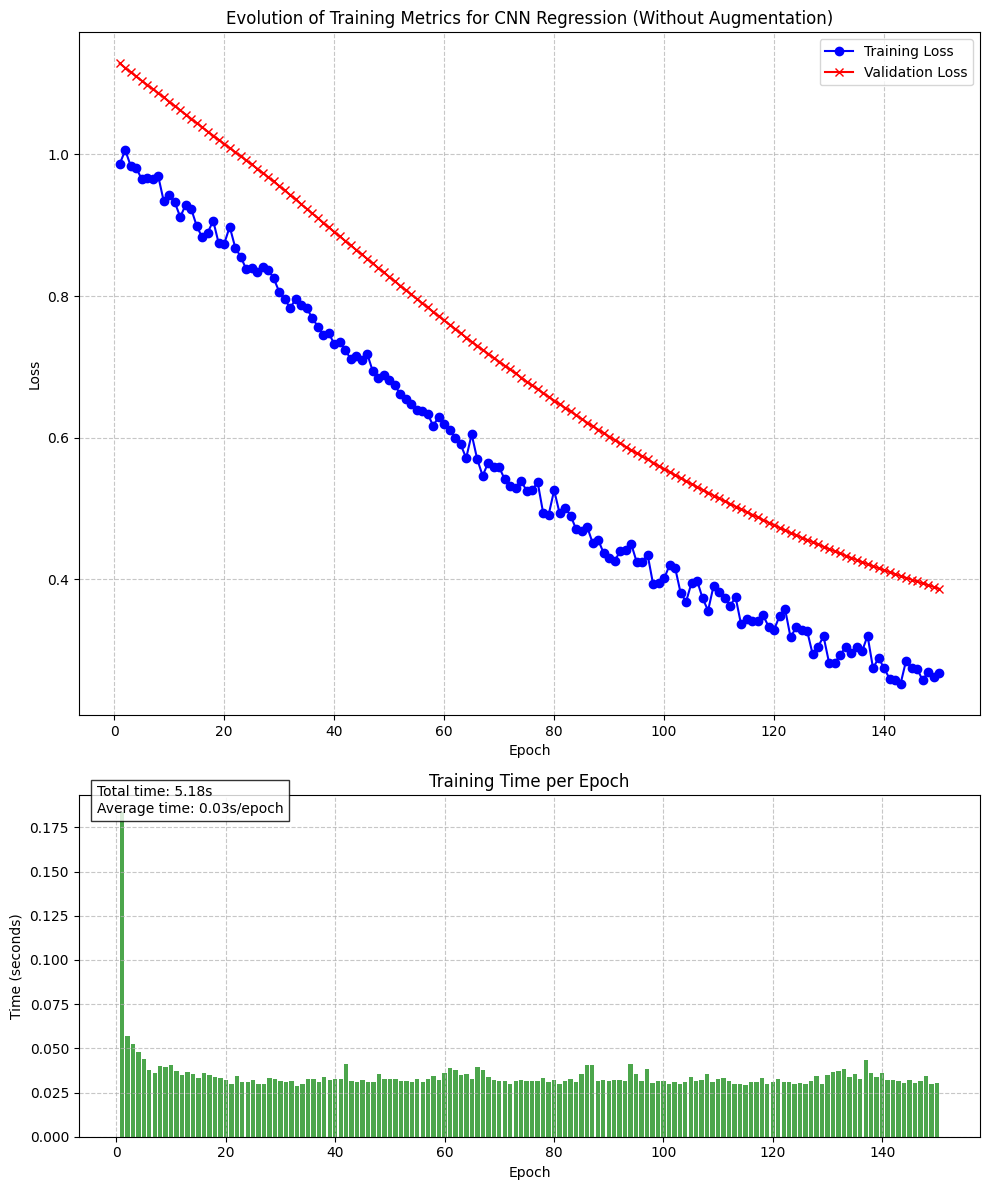

In [9]:

# Print evaluation metrics
print_regression_metrics(test_targets, test_predictions, "test")

# Visualize the evolution of metrics
plot_regression_metrics_sequence(
    metrics_history,
    title="Evolution of Training Metrics for CNN Regression (Without Augmentation)",
)


#### With Data augmentation

##### Data preparation

In [11]:

# Re-use the same train-test-validation split
train_data = data_3cl.iloc[indices_train].copy()
val_data = data_3cl.iloc[indices_val].copy()
test_data = data_3cl.iloc[indices_test].copy()

# Create augmentation parameters
augmentation_params = AugmentationParams(
    mixup_alpha=0.4,  # Higher alpha for more diverse mixing
    gaussian_noise_std=0.03,  # Increased noise for better robustness
    jitter_factor=0.04,  # More intensity variation
    augmentation_probability=0.8,  # Higher probability of applying augmentation
    by=["symptom", "variety", "plotLocation"],  # Group by these columns
    batch_size=100,  # Generate 100 samples per group
    exclude_columns=None,  # Don't exclude any columns to keep all spectral data
)

# Create augmenter and augment training data
augmenter = DataAugmenter(augmentation_params)
train_data_augmented = augmenter.augment(train_data)

print(f"Training set (original): {len(train_data)} samples")
print(f"Training set (after augmentation): {len(train_data_augmented)} samples")
print(f"Validation set: {len(val_data)} samples")
print(f"Test set: {len(test_data)} samples")


C:\Users\Guilhem\code\SUPAGRO\hyperspectral-analysis\src\data_augmenter.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_df in df.groupby(self.params.by):
C:\Users\Guilhem\code\SUPAGRO\hyperspectral-analysis\src\data_augmenter.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_df in df.groupby(self.params.by):
C:\Users\Guilhem\code\SUPAGRO\hyperspectral-analysis\src\data_augmenter.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

Training set (original): 122 samples
Training set (after augmentation): 3900 samples
Validation set: 31 samples
Test set: 51 samples


##### Main loop

In [12]:

# Prepare features and targets for different sets with augmented data
X_train_reg = np.array(train_data_augmented[spectral_cols])
y_train_reg = np.array(train_data_augmented["Chl"]).reshape(-1, 1)

X_val_reg = np.array(val_data[spectral_cols])
y_val_reg = np.array(val_data["Chl"]).reshape(-1, 1)

X_test_reg = np.array(test_data[spectral_cols])
y_test_reg = np.array(test_data["Chl"]).reshape(-1, 1)

# Standardize features for regression
scaler_X_reg = StandardScaler()
scaler_y_Chl = StandardScaler()

X_train_reg = scaler_X_reg.fit_transform(X_train_reg)
X_val_reg = scaler_X_reg.transform(X_val_reg)
X_test_reg = scaler_X_reg.transform(X_test_reg)

y_train_chl = scaler_y_Chl.fit_transform(y_train_reg)
y_val_chl = scaler_y_Chl.transform(y_val_reg)
y_test_chl = scaler_y_Chl.transform(y_test_reg)

# Create datasets and loaders for training and validation only
train_dataset = SpectralDataset(X_train_reg, y_train_chl)
val_dataset = SpectralDataset(X_val_reg, y_val_chl)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Initialize model, loss function and optimizer
model_aug = CNNModel(input_dim=len(spectral_cols))
criterion = nn.MSELoss()
optimizer = optim.Adam(model_aug.parameters(), lr=LEARNING_RATE)

# Training loop
best_val_loss = float("inf")
best_model_state = None

# List to store training metrics
metrics_history: List[RegressionMetrics] = []

print("Starting CNN training for regression with augmentation...")
total_training_start = time.time()
for epoch in range(N_EPOCHS):
    epoch_start = time.time()
    # Set model to training mode
    model_aug.train()
    # Initialize the total training loss for this epoch
    train_loss = 0.0
    # Iterate over mini-batches of training data
    for X_batch, y_batch in train_loader:
        # Reset gradients to zero before computing new gradients
        optimizer.zero_grad()
        # Forward pass: compute model predictions
        outputs = model_aug(X_batch)
        # Compute the loss between predictions and true values
        loss = criterion(outputs, y_batch)
        # Backward pass: compute gradients of the loss
        loss.backward()
        # Update model parameters using the optimizer
        optimizer.step()
        # Accumulate the batch loss
        train_loss += loss.item()

    # Validation phase
    model_aug.eval()
    # Initialize the total validation loss for this epoch
    val_loss = 0.0
    # Disable gradient computation for validation
    with torch.no_grad():
        # Iterate over mini-batches of validation data
        for X_batch, y_batch in val_loader:
            # Forward pass only
            outputs = model_aug(X_batch)
            # Accumulate the validation loss
            val_loss += criterion(outputs, y_batch).item()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    # Calculate epoch execution time
    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start

    # Store metrics for each epoch
    metrics_history.append(
        RegressionMetrics(
            epoch=epoch + 1,
            train_loss=avg_train_loss,
            val_loss=avg_val_loss,
            epoch_time=epoch_time,
        )
    )

    # Keep track of the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model_aug.state_dict().copy()

    # Print metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{N_EPOCHS}]")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Epoch Time: {epoch_time:.2f}s")
        print("-" * 50)

total_training_end = time.time()
total_training_time = total_training_end - total_training_start
print(f"Total training time: {total_training_time:.2f} seconds")
print(f"Average time per epoch: {total_training_time/N_EPOCHS:.2f} seconds")

# Load the best model
if best_model_state is not None:
    model_aug.load_state_dict(best_model_state)
    print(f"Best model loaded with validation loss of {best_val_loss:.4f}")

# Evaluation on test set
model_aug.eval()
with torch.no_grad():
    # Convert test data to tensors directly
    X_test_tensor = torch.FloatTensor(X_test_reg).unsqueeze(1)  # Add channel dimension
    y_test_tensor = torch.FloatTensor(y_test_chl)

    # Get predictions for all test data at once
    test_predictions = model_aug(X_test_tensor).detach().numpy()
    test_targets = y_test_tensor.detach().numpy()

# Convert predictions back to original scale
test_predictions = scaler_y_Chl.inverse_transform(test_predictions)
test_targets = scaler_y_Chl.inverse_transform(test_targets)


Starting CNN training for regression with augmentation...
Epoch [10/150]
Train Loss: 0.2400
Val Loss: 0.4478
Epoch Time: 1.38s
--------------------------------------------------
Epoch [20/150]
Train Loss: 0.1910
Val Loss: 0.3825
Epoch Time: 0.84s
--------------------------------------------------
Epoch [30/150]
Train Loss: 0.1729
Val Loss: 0.3707
Epoch Time: 0.87s
--------------------------------------------------
Epoch [40/150]
Train Loss: 0.1544
Val Loss: 0.3598
Epoch Time: 0.89s
--------------------------------------------------
Epoch [50/150]
Train Loss: 0.1467
Val Loss: 0.3769
Epoch Time: 1.48s
--------------------------------------------------
Epoch [60/150]
Train Loss: 0.1357
Val Loss: 0.3873
Epoch Time: 2.28s
--------------------------------------------------
Epoch [70/150]
Train Loss: 0.1305
Val Loss: 0.3938
Epoch Time: 0.94s
--------------------------------------------------
Epoch [80/150]
Train Loss: 0.1242
Val Loss: 0.3817
Epoch Time: 1.13s
---------------------------------

##### Conclusion


R² score on test set: 0.7614
MSE on test set: 17.3557
RMSE on test set: 4.1660
MAE on test set: 3.2384


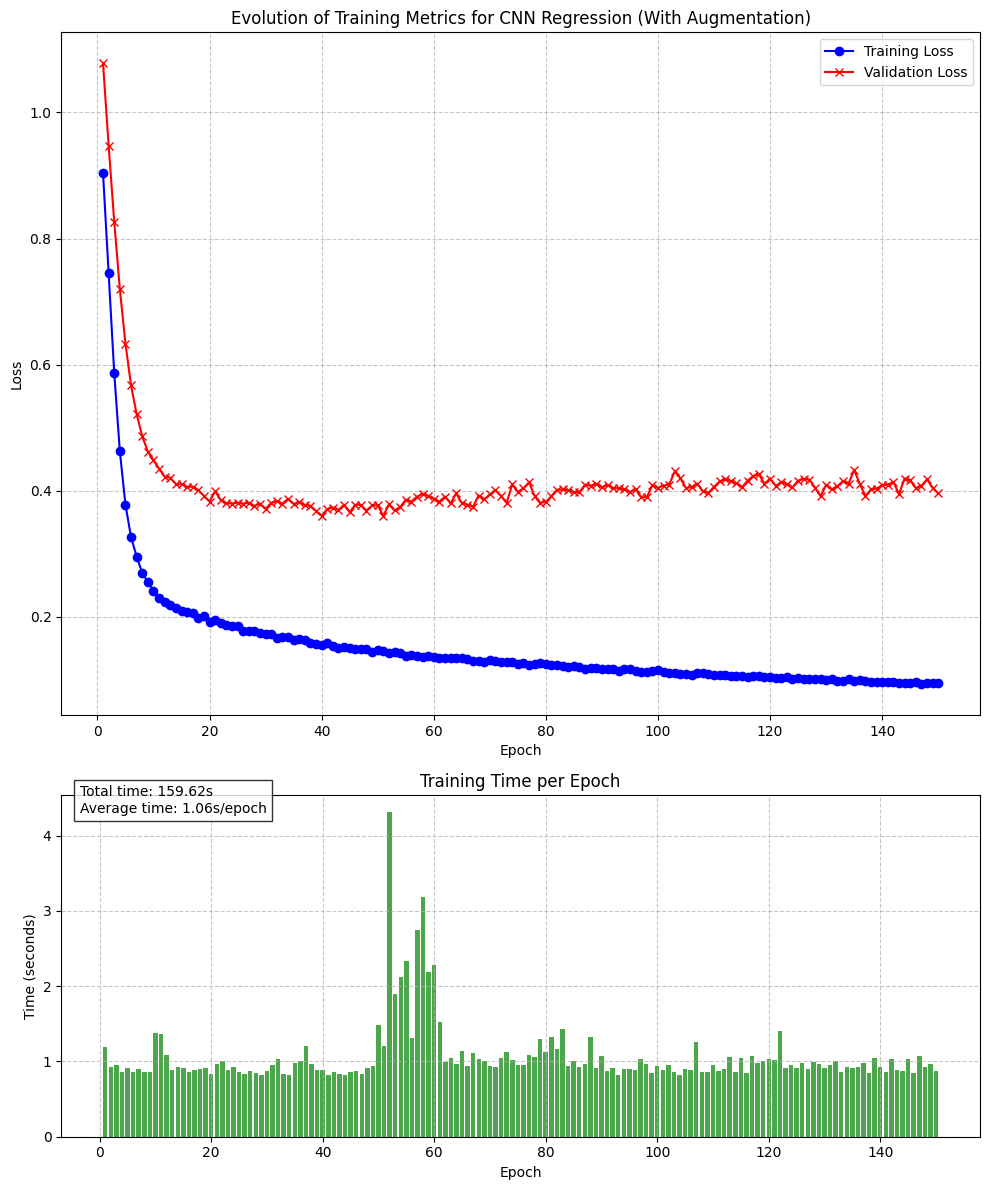

In [13]:

# Print evaluation metrics
print_regression_metrics(test_targets, test_predictions, "test")

# Visualize the evolution of metrics
plot_regression_metrics_sequence(
    metrics_history,
    title="Evolution of Training Metrics for CNN Regression (With Augmentation)"
)


#### Comparaison

R² score (standard): 0.7244
R² score (augmented): 0.7614
Improvement: 5.11%

MSE (standard): 20.0488
MSE (augmented): 17.3557
Improvement: 13.43%

RMSE (standard): 4.4776
RMSE (augmented): 4.1660
Improvement: 6.96%

MAE (standard): 3.6137
MAE (augmented): 3.2384
Improvement: 10.39%


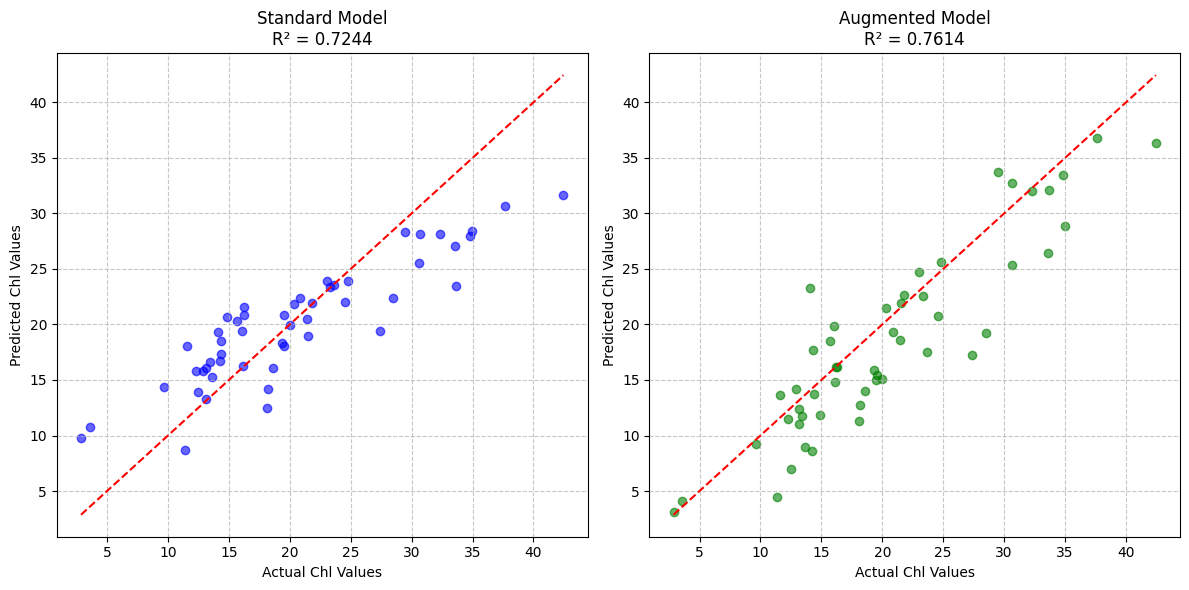

In [14]:
# Compare the two models by evaluating both on the test set
model.eval()
model_aug.eval()

with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test_reg).unsqueeze(1)

    # Get predictions from both models
    test_pred_standard = model(X_test_tensor).detach().numpy()
    test_pred_augmented = model_aug(X_test_tensor).detach().numpy()

    # Convert back to original scale
    test_pred_standard = scaler_y_Chl.inverse_transform(test_pred_standard)
    test_pred_augmented = scaler_y_Chl.inverse_transform(test_pred_augmented)
    test_targets = scaler_y_Chl.inverse_transform(y_test_chl)

# Calculate metrics for both models
r2_standard = r2_score(test_targets, test_pred_standard)
r2_augmented = r2_score(test_targets, test_pred_augmented)

mse_standard = mean_squared_error(test_targets, test_pred_standard)
mse_augmented = mean_squared_error(test_targets, test_pred_augmented)

rmse_standard = np.sqrt(mse_standard)
rmse_augmented = np.sqrt(mse_augmented)

mae_standard = mean_absolute_error(test_targets, test_pred_standard)
mae_augmented = mean_absolute_error(test_targets, test_pred_augmented)

print(f"R² score (standard): {r2_standard:.4f}")
print(f"R² score (augmented): {r2_augmented:.4f}")
print(f"Improvement: {(r2_augmented - r2_standard) / r2_standard * 100:.2f}%")
print()

print(f"MSE (standard): {mse_standard:.4f}")
print(f"MSE (augmented): {mse_augmented:.4f}")
print(f"Improvement: {(mse_standard - mse_augmented) / mse_standard * 100:.2f}%")
print()

print(f"RMSE (standard): {rmse_standard:.4f}")
print(f"RMSE (augmented): {rmse_augmented:.4f}")
print(f"Improvement: {(rmse_standard - rmse_augmented) / rmse_standard * 100:.2f}%")
print()

print(f"MAE (standard): {mae_standard:.4f}")
print(f"MAE (augmented): {mae_augmented:.4f}")
print(f"Improvement: {(mae_standard - mae_augmented) / mae_standard * 100:.2f}%")

# Visualize predictions from both models
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(test_targets, test_pred_standard, alpha=0.6, c="blue")
plt.plot(
    [np.min(test_targets), np.max(test_targets)],
    [np.min(test_targets), np.max(test_targets)],
    "r--",
)
plt.xlabel("Actual Chl Values")
plt.ylabel("Predicted Chl Values")
plt.title(f"Standard Model\nR² = {r2_standard:.4f}")
plt.grid(True, linestyle="--", alpha=0.7)

plt.subplot(1, 2, 2)
plt.scatter(test_targets, test_pred_augmented, alpha=0.6, c="green")
plt.plot(
    [np.min(test_targets), np.max(test_targets)],
    [np.min(test_targets), np.max(test_targets)],
    "r--",
)
plt.xlabel("Actual Chl Values")
plt.ylabel("Predicted Chl Values")
plt.title(f"Augmented Model\nR² = {r2_augmented:.4f}")
plt.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


### With pretreatment

When using the pretreatments, we need to refine/rewrite our model, to take into account the increased dimensionality and structure of our feature space. Notice that there is a convultional subnetwork for each network, before beeing merged on a dense layer.

In [18]:

# Custom Dataset class for spectral data with multiple transformations
class MultiSpectralDataset(Dataset):
    """Dataset class to handle multiple spectral data transformations for PyTorch"""

    def __init__(
        self,
        X_original: np.ndarray | spmatrix,
        X_snv_sg: np.ndarray | spmatrix,
        X_deriv1: np.ndarray | spmatrix,
        X_deriv2: np.ndarray | spmatrix,
        y: np.ndarray | spmatrix,
    ):
        # Reshape each X for CNN input: [batch_size, channels, sequence_length]
        self.X_original = torch.FloatTensor(X_original).unsqueeze(
            1
        )  # Add channel dimension
        self.X_snv_sg = torch.FloatTensor(X_snv_sg).unsqueeze(1)
        self.X_deriv1 = torch.FloatTensor(X_deriv1).unsqueeze(1)
        self.X_deriv2 = torch.FloatTensor(X_deriv2).unsqueeze(1)
        self.y = torch.FloatTensor(y)  # FloatTensor for regression targets

    def __len__(self) -> int:
        return len(self.X_original)

    def __getitem__(self, idx: int) -> tuple[list[torch.Tensor], torch.Tensor]:
        return [
            self.X_original[idx],
            self.X_snv_sg[idx],
            self.X_deriv1[idx],
            self.X_deriv2[idx],
        ], self.y[idx]


# CNN model with multiple inputs for regression
class MultiInputCNNModel(nn.Module):
    """CNN model with parallel paths for multiple spectral transformations

    Args:
        input_dim: Length of the spectral sequence
        output_dim: Number of outputs (1 for single value regression)
    """

    def __init__(
        self,
        input_dim: int,
        output_dim: int = 1,
        kernel_size: int = KERNEL_SIZE,
        stride: int = STRIDE,
        padding: int = PADDING,
    ):
        super().__init__()

        # Calculate output size of first conv layer
        conv1_output_size = ((input_dim + 2 * padding - kernel_size) // stride) + 1

        # Calculate output size after pooling
        pool1_output_size = conv1_output_size // 2

        # Calculate output size of second conv layer
        conv2_output_size = (
            (pool1_output_size + 2 * padding - kernel_size) // stride
        ) + 1

        # Calculate output size after pooling
        pool2_output_size = conv2_output_size // 2

        # Define CNN path for original spectral data
        self.cnn_original = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=16,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(
                in_channels=16,
                out_channels=32,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # Define CNN path for SNV + Savitzky-Golay transformed data
        self.cnn_snv_sg = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=16,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(
                in_channels=16,
                out_channels=32,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # Define CNN path for first derivative transformed data
        self.cnn_deriv1 = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=16,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(
                in_channels=16,
                out_channels=32,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # Define CNN path for second derivative transformed data
        self.cnn_deriv2 = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=16,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(
                in_channels=16,
                out_channels=32,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # Calculate total features after concatenation
        total_features = 32 * pool2_output_size * 4  # 4 paths

        # Fully connected layers that combine all paths for regression
        self.fc = nn.Sequential(
            nn.Linear(total_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),  # Prevent overfitting
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_dim),
        )

    def forward(self, x_list: list[torch.Tensor]) -> torch.Tensor:
        # Process each input through its respective CNN path
        x_original = self.cnn_original(x_list[0])
        x_snv_sg = self.cnn_snv_sg(x_list[1])
        x_deriv1 = self.cnn_deriv1(x_list[2])
        x_deriv2 = self.cnn_deriv2(x_list[3])

        # Flatten each output
        x_original = x_original.view(x_original.size(0), -1)
        x_snv_sg = x_snv_sg.view(x_snv_sg.size(0), -1)
        x_deriv1 = x_deriv1.view(x_deriv1.size(0), -1)
        x_deriv2 = x_deriv2.view(x_deriv2.size(0), -1)

        # Concatenate all flattened outputs
        x_combined = torch.cat([x_original, x_snv_sg, x_deriv1, x_deriv2], dim=1)

        # Pass through fully connected layers
        return self.fc(x_combined)



#### Without Data augmentation

##### Data preparation

In [19]:
# Preparing data for regression
indices = np.arange(len(data_3cl))
indices_train_temp, indices_test = train_test_split(
    indices, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

indices_train, indices_val = train_test_split(
    indices_train_temp, test_size=VAL_SIZE, random_state=RANDOM_SEED
)

# Display set sizes
print(f"Training set: {len(indices_train)} samples")
print(f"Validation set: {len(indices_val)} samples")
print(f"Test set: {len(indices_test)} samples")

# Create datasets
train_data = data_3cl.iloc[indices_train].copy()
val_data = data_3cl.iloc[indices_val].copy()
test_data = data_3cl.iloc[indices_test].copy()

# Prepare features and targets for different sets
# Get original spectral data
X_train_original = np.array(train_data[spectral_cols])
X_val_original = np.array(val_data[spectral_cols])
X_test_original = np.array(test_data[spectral_cols])

# Get SNV+SG transformed data
X_train_snv_sg = np.array(mat_snv_sg_3cl.iloc[indices_train][spectral_cols])
X_val_snv_sg = np.array(mat_snv_sg_3cl.iloc[indices_val][spectral_cols])
X_test_snv_sg = np.array(mat_snv_sg_3cl.iloc[indices_test][spectral_cols])

# Get first derivative transformed data
X_train_deriv1 = np.array(mat_deriv1_3cl.iloc[indices_train][spectral_cols])
X_val_deriv1 = np.array(mat_deriv1_3cl.iloc[indices_val][spectral_cols])
X_test_deriv1 = np.array(mat_deriv1_3cl.iloc[indices_test][spectral_cols])

# Get second derivative transformed data
X_train_deriv2 = np.array(mat_deriv2_3cl.iloc[indices_train][spectral_cols])
X_val_deriv2 = np.array(mat_deriv2_3cl.iloc[indices_val][spectral_cols])
X_test_deriv2 = np.array(mat_deriv2_3cl.iloc[indices_test][spectral_cols])

# Get target variables (Chl values)
y_train_reg = np.array(train_data["Chl"]).reshape(-1, 1)
y_val_reg = np.array(val_data["Chl"]).reshape(-1, 1)
y_test_reg = np.array(test_data["Chl"]).reshape(-1, 1)

# Standardize each spectral dataset
scaler_original = StandardScaler()
scaler_snv_sg = StandardScaler()
scaler_deriv1 = StandardScaler()
scaler_deriv2 = StandardScaler()
scaler_y_Chl = StandardScaler()

# Scale original spectral data
X_train_original = scaler_original.fit_transform(X_train_original)
X_val_original = scaler_original.transform(X_val_original)
X_test_original = scaler_original.transform(X_test_original)

# Scale SNV+SG transformed data
X_train_snv_sg = scaler_snv_sg.fit_transform(X_train_snv_sg)
X_val_snv_sg = scaler_snv_sg.transform(X_val_snv_sg)
X_test_snv_sg = scaler_snv_sg.transform(X_test_snv_sg)

# Scale first derivative transformed data
X_train_deriv1 = scaler_deriv1.fit_transform(X_train_deriv1)
X_val_deriv1 = scaler_deriv1.transform(X_val_deriv1)
X_test_deriv1 = scaler_deriv1.transform(X_test_deriv1)

# Scale second derivative transformed data
X_train_deriv2 = scaler_deriv2.fit_transform(X_train_deriv2)
X_val_deriv2 = scaler_deriv2.transform(X_val_deriv2)
X_test_deriv2 = scaler_deriv2.transform(X_test_deriv2)

# Scale target variables
y_train_chl = scaler_y_Chl.fit_transform(y_train_reg)
y_val_chl = scaler_y_Chl.transform(y_val_reg)
y_test_chl = scaler_y_Chl.transform(y_test_reg)

# Create datasets and loaders for training and validation
train_dataset = MultiSpectralDataset(
    X_train_original, X_train_snv_sg, X_train_deriv1, X_train_deriv2, y_train_chl
)
val_dataset = MultiSpectralDataset(
    X_val_original, X_val_snv_sg, X_val_deriv1, X_val_deriv2, y_val_chl
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


Training set: 122 samples
Validation set: 31 samples
Test set: 51 samples


##### Model, criterion and optimizer

In [20]:

# Initialize model, loss function and optimizer
model = MultiInputCNNModel(input_dim=len(spectral_cols))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
summary(model)

Layer (type:depth-idx)                   Param #
MultiInputCNNModel                       --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       64
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
│    └─Conv1d: 2-4                       1,568
│    └─ReLU: 2-5                         --
│    └─MaxPool1d: 2-6                    --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-7                       64
│    └─ReLU: 2-8                         --
│    └─MaxPool1d: 2-9                    --
│    └─Conv1d: 2-10                      1,568
│    └─ReLU: 2-11                        --
│    └─MaxPool1d: 2-12                   --
├─Sequential: 1-3                        --
│    └─Conv1d: 2-13                      64
│    └─ReLU: 2-14                        --
│    └─MaxPool1d: 2-15                   --
│    └─Conv1d: 2-16                      1,568
│    └─ReLU: 2-17                        --
│    └─MaxPool1d: 

##### Main loop

In [ ]:

# Training loop
best_val_loss = float("inf")
best_model_state = None

# List to store training metrics
metrics_history: List[RegressionMetrics] = []

print("Starting CNN training for regression with preprocessing...")
total_training_start = time.time()
for epoch in range(N_EPOCHS):
    epoch_start = time.time()
    # Set model to training mode
    model.train()
    # Initialize the total training loss for this epoch
    train_loss = 0.0
    # Iterate over mini-batches of training data
    for X_batch, y_batch in train_loader:
        # Reset gradients to zero before computing new gradients
        optimizer.zero_grad()
        # Forward pass: compute model predictions
        outputs = model(X_batch)
        # Compute the loss between predictions and true values
        loss = criterion(outputs, y_batch)
        # Backward pass: compute gradients of the loss
        loss.backward()
        # Update model parameters using the optimizer
        optimizer.step()
        # Accumulate the batch loss
        train_loss += loss.item()

    # Validation phase
    model.eval()
    # Initialize the total validation loss for this epoch
    val_loss = 0.0
    # Disable gradient computation for validation
    with torch.no_grad():
        # Iterate over mini-batches of validation data
        for X_batch, y_batch in val_loader:
            # Forward pass only
            outputs = model(X_batch)
            # Compute and accumulate the validation loss
            val_loss += criterion(outputs, y_batch).item()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    # Calculate epoch execution time
    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start

    # Store metrics for each epoch
    metrics_history.append(
        RegressionMetrics(
            epoch=epoch + 1,
            train_loss=avg_train_loss,
            val_loss=avg_val_loss,
            epoch_time=epoch_time,
        )
    )

    # Keep track of the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict().copy()

    # Print metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{N_EPOCHS}]")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Epoch Time: {epoch_time:.2f}s")
        print("-" * 50)

total_training_end = time.time()
total_training_time = total_training_end - total_training_start
print(f"Total training time: {total_training_time:.2f} seconds")
print(f"Average time per epoch: {total_training_time/N_EPOCHS:.2f} seconds")

# Load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(
        f"Best model loaded with validation loss of {best_val_loss/len(val_loader):.4f}"
    )

# Evaluation on test set
model.eval()
with torch.no_grad():
    # Create dataset for test data
    test_inputs = [
        torch.FloatTensor(X_test_original).unsqueeze(1),
        torch.FloatTensor(X_test_snv_sg).unsqueeze(1),
        torch.FloatTensor(X_test_deriv1).unsqueeze(1),
        torch.FloatTensor(X_test_deriv2).unsqueeze(1),
    ]
    test_targets = torch.FloatTensor(y_test_chl)

    # Get predictions for all test data at once
    test_predictions = model(test_inputs).detach().numpy()
    test_targets = test_targets.detach().numpy()

# Convert predictions back to original scale
test_predictions = scaler_y_Chl.inverse_transform(test_predictions)
test_targets = scaler_y_Chl.inverse_transform(test_targets)


##### Conclusion


R² score on test set: 0.7614
MSE on test set: 17.3557
RMSE on test set: 4.1660
MAE on test set: 3.2384


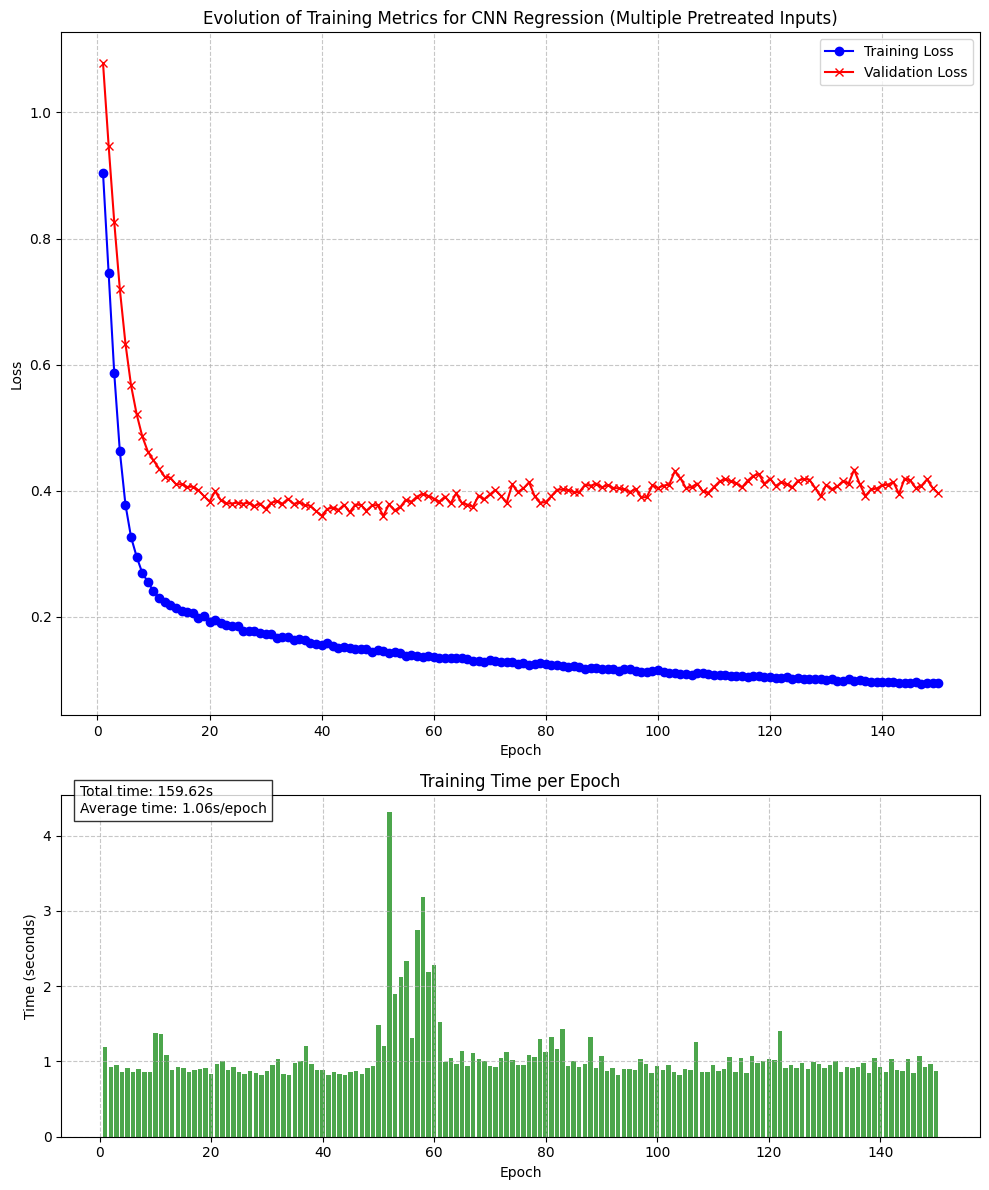

In [21]:

# Print evaluation metrics
print_regression_metrics(test_targets, test_predictions, "test")

# Visualize the evolution of metrics
plot_regression_metrics_sequence(
    metrics_history,
    title="Evolution of Training Metrics for CNN Regression (Multiple Pretreated Inputs)"
)



#### Data augmentation

##### Data preparation

In [22]:

# Re-use the same train-test-validation split
train_data = data_3cl.iloc[indices_train].copy()
val_data = data_3cl.iloc[indices_val].copy()
test_data = data_3cl.iloc[indices_test].copy()

# Create augmentation parameters
augmentation_params = AugmentationParams(
    mixup_alpha=0.4,  # Higher alpha for more diverse mixing
    gaussian_noise_std=0.03,  # Increased noise for better robustness
    jitter_factor=0.04,  # More intensity variation
    augmentation_probability=0.8,  # Higher probability of applying augmentation
    by=["symptom", "variety", "plotLocation"],  # Group by these columns
    batch_size=100,  # Generate 100 samples per group
    exclude_columns=None,  # Don't exclude any columns to keep all spectral data
)

# Create augmenter and augment training data
augmenter = DataAugmenter(augmentation_params)
train_data_augmented = augmenter.augment(train_data)

print(f"Training set (original): {len(train_data)} samples")
print(f"Training set (after augmentation): {len(train_data_augmented)} samples")
print(f"Validation set: {len(val_data)} samples")
print(f"Test set: {len(test_data)} samples")

# Prepare original spectral features (augmented)
X_train_original = np.array(train_data_augmented[spectral_cols])
X_val_original = np.array(val_data[spectral_cols])
X_test_original = np.array(test_data[spectral_cols])

# Get target variables (Chl values - augmented)
y_train_reg = np.array(train_data_augmented["Chl"]).reshape(-1, 1)
y_val_reg = np.array(val_data["Chl"]).reshape(-1, 1)
y_test_reg = np.array(test_data["Chl"]).reshape(-1, 1)

# We need to re-apply transformations on the augmented data
# First, get the transformers from dataLoading module
from scripts.dataLoading import (
    snv_transformer,
    sg_smoother,
    derivative1,
    derivative2,
)

# Apply transformations on augmented data
# SNV + SG transformation
X_train_snv_sg = sg_smoother.transform(snv_transformer.transform(X_train_original))
# First derivative transformation
X_train_deriv1 = derivative1.transform(X_train_original)
# Second derivative transformation
X_train_deriv2 = derivative2.transform(X_train_original)

# For validation and test, we keep the existing transformed data
X_val_snv_sg = np.array(mat_snv_sg_3cl.iloc[indices_val][spectral_cols])
X_test_snv_sg = np.array(mat_snv_sg_3cl.iloc[indices_test][spectral_cols])

X_val_deriv1 = np.array(mat_deriv1_3cl.iloc[indices_val][spectral_cols])
X_test_deriv1 = np.array(mat_deriv1_3cl.iloc[indices_test][spectral_cols])

X_val_deriv2 = np.array(mat_deriv2_3cl.iloc[indices_val][spectral_cols])
X_test_deriv2 = np.array(mat_deriv2_3cl.iloc[indices_test][spectral_cols])

# Standardize each spectral dataset
scaler_original_aug = StandardScaler()
scaler_snv_sg_aug = StandardScaler()
scaler_deriv1_aug = StandardScaler()
scaler_deriv2_aug = StandardScaler()
scaler_y_Chl_aug = StandardScaler()

# Scale original spectral data
X_train_original = scaler_original_aug.fit_transform(X_train_original)
X_val_original = scaler_original_aug.transform(X_val_original)
X_test_original = scaler_original_aug.transform(X_test_original)

# Scale SNV+SG transformed data
X_train_snv_sg = scaler_snv_sg_aug.fit_transform(X_train_snv_sg)
X_val_snv_sg = scaler_snv_sg_aug.transform(X_val_snv_sg)
X_test_snv_sg = scaler_snv_sg_aug.transform(X_test_snv_sg)

# Scale first derivative transformed data
X_train_deriv1 = scaler_deriv1_aug.fit_transform(X_train_deriv1)
X_val_deriv1 = scaler_deriv1_aug.transform(X_val_deriv1)
X_test_deriv1 = scaler_deriv1_aug.transform(X_test_deriv1)

# Scale second derivative transformed data
X_train_deriv2 = scaler_deriv2_aug.fit_transform(X_train_deriv2)
X_val_deriv2 = scaler_deriv2_aug.transform(X_val_deriv2)
X_test_deriv2 = scaler_deriv2_aug.transform(X_test_deriv2)

# Scale target variables
y_train_chl = scaler_y_Chl_aug.fit_transform(y_train_reg)
y_val_chl = scaler_y_Chl_aug.transform(y_val_reg)
y_test_chl = scaler_y_Chl_aug.transform(y_test_reg)

# Create datasets and loaders for training and validation
train_dataset = MultiSpectralDataset(
    X_train_original, X_train_snv_sg, X_train_deriv1, X_train_deriv2, y_train_chl
)
val_dataset = MultiSpectralDataset(
    X_val_original, X_val_snv_sg, X_val_deriv1, X_val_deriv2, y_val_chl
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


C:\Users\Guilhem\code\SUPAGRO\hyperspectral-analysis\src\data_augmenter.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_df in df.groupby(self.params.by):
C:\Users\Guilhem\code\SUPAGRO\hyperspectral-analysis\src\data_augmenter.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_df in df.groupby(self.params.by):
C:\Users\Guilhem\code\SUPAGRO\hyperspectral-analysis\src\data_augmenter.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

Training set (original): 122 samples
Training set (after augmentation): 3900 samples
Validation set: 31 samples
Test set: 51 samples


##### Main loop

In [23]:

# Initialize model, loss function and optimizer
model_aug = MultiInputCNNModel(input_dim=len(spectral_cols))
criterion = nn.MSELoss()
optimizer = optim.Adam(model_aug.parameters(), lr=LEARNING_RATE)
summary(model_aug)

Layer (type:depth-idx)                   Param #
MultiInputCNNModel                       --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       64
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
│    └─Conv1d: 2-4                       1,568
│    └─ReLU: 2-5                         --
│    └─MaxPool1d: 2-6                    --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-7                       64
│    └─ReLU: 2-8                         --
│    └─MaxPool1d: 2-9                    --
│    └─Conv1d: 2-10                      1,568
│    └─ReLU: 2-11                        --
│    └─MaxPool1d: 2-12                   --
├─Sequential: 1-3                        --
│    └─Conv1d: 2-13                      64
│    └─ReLU: 2-14                        --
│    └─MaxPool1d: 2-15                   --
│    └─Conv1d: 2-16                      1,568
│    └─ReLU: 2-17                        --
│    └─MaxPool1d: 

In [24]:

# Training loop
best_val_loss = float("inf")
best_model_state = None

# List to store training metrics
metrics_history: List[RegressionMetrics] = []

print(
    "Starting CNN training for regression with preprocessing and data augmentation..."
)
total_training_start = time.time()
for epoch in range(N_EPOCHS):
    epoch_start = time.time()
    # Set model to training mode
    model_aug.train()
    # Initialize the total training loss for this epoch
    train_loss = 0.0
    # Iterate over mini-batches of training data
    for X_batch, y_batch in train_loader:
        # Reset gradients to zero before computing new gradients
        optimizer.zero_grad()
        # Forward pass: compute model predictions
        outputs = model_aug(X_batch)
        # Compute the loss between predictions and true values
        loss = criterion(outputs, y_batch)
        # Backward pass: compute gradients of the loss
        loss.backward()
        # Update model parameters using the optimizer
        optimizer.step()
        # Accumulate the batch loss
        train_loss += loss.item()

    # Validation phase
    model_aug.eval()
    # Initialize the total validation loss for this epoch
    val_loss = 0.0
    # Disable gradient computation for validation
    with torch.no_grad():
        # Iterate over mini-batches of validation data
        for X_batch, y_batch in val_loader:
            # Forward pass only
            outputs = model_aug(X_batch)
            # Compute and accumulate the validation loss
            val_loss += criterion(outputs, y_batch).item()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    # Calculate epoch execution time
    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start

    # Store metrics for each epoch
    metrics_history.append(
        RegressionMetrics(
            epoch=epoch + 1,
            train_loss=avg_train_loss,
            val_loss=avg_val_loss,
            epoch_time=epoch_time,
        )
    )

    # Keep track of the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model_aug.state_dict().copy()

    # Print metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{N_EPOCHS}]")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Epoch Time: {epoch_time:.2f}s")
        print("-" * 50)

total_training_end = time.time()
total_training_time = total_training_end - total_training_start
print(f"Total training time: {total_training_time:.2f} seconds")
print(f"Average time per epoch: {total_training_time/N_EPOCHS:.2f} seconds")

# Load the best model
if best_model_state is not None:
    model_aug.load_state_dict(best_model_state)
    print(
        f"Best model loaded with validation loss of {best_val_loss/len(val_loader):.4f}"
    )

# Evaluation on test set
model_aug.eval()
with torch.no_grad():
    # Create dataset for test data
    test_inputs = [
        torch.FloatTensor(X_test_original).unsqueeze(1),
        torch.FloatTensor(X_test_snv_sg).unsqueeze(1),
        torch.FloatTensor(X_test_deriv1).unsqueeze(1),
        torch.FloatTensor(X_test_deriv2).unsqueeze(1),
    ]
    test_targets = torch.FloatTensor(y_test_chl)

    # Get predictions for all test data at once
    test_predictions = model_aug(test_inputs).detach().numpy()
    test_targets = test_targets.detach().numpy()

# Convert predictions back to original scale
test_predictions = scaler_y_Chl_aug.inverse_transform(test_predictions)
test_targets = scaler_y_Chl_aug.inverse_transform(test_targets)


Starting CNN training for regression with preprocessing and data augmentation...
Epoch [10/150]
Train Loss: 0.1695
Val Loss: 0.2591
Epoch Time: 3.71s
--------------------------------------------------
Epoch [20/150]
Train Loss: 0.1424
Val Loss: 0.2440
Epoch Time: 3.93s
--------------------------------------------------
Epoch [30/150]
Train Loss: 0.1283
Val Loss: 0.2353
Epoch Time: 3.50s
--------------------------------------------------
Epoch [40/150]
Train Loss: 0.1161
Val Loss: 0.2391
Epoch Time: 4.51s
--------------------------------------------------
Epoch [50/150]
Train Loss: 0.1013
Val Loss: 0.2584
Epoch Time: 3.52s
--------------------------------------------------
Epoch [60/150]
Train Loss: 0.0908
Val Loss: 0.2669
Epoch Time: 3.75s
--------------------------------------------------
Epoch [70/150]
Train Loss: 0.0826
Val Loss: 0.2727
Epoch Time: 3.66s
--------------------------------------------------
Epoch [80/150]
Train Loss: 0.0751
Val Loss: 0.2769
Epoch Time: 3.56s
----------


R² score on test set: 0.7966
MSE on test set: 14.7955
RMSE on test set: 3.8465
MAE on test set: 2.9440


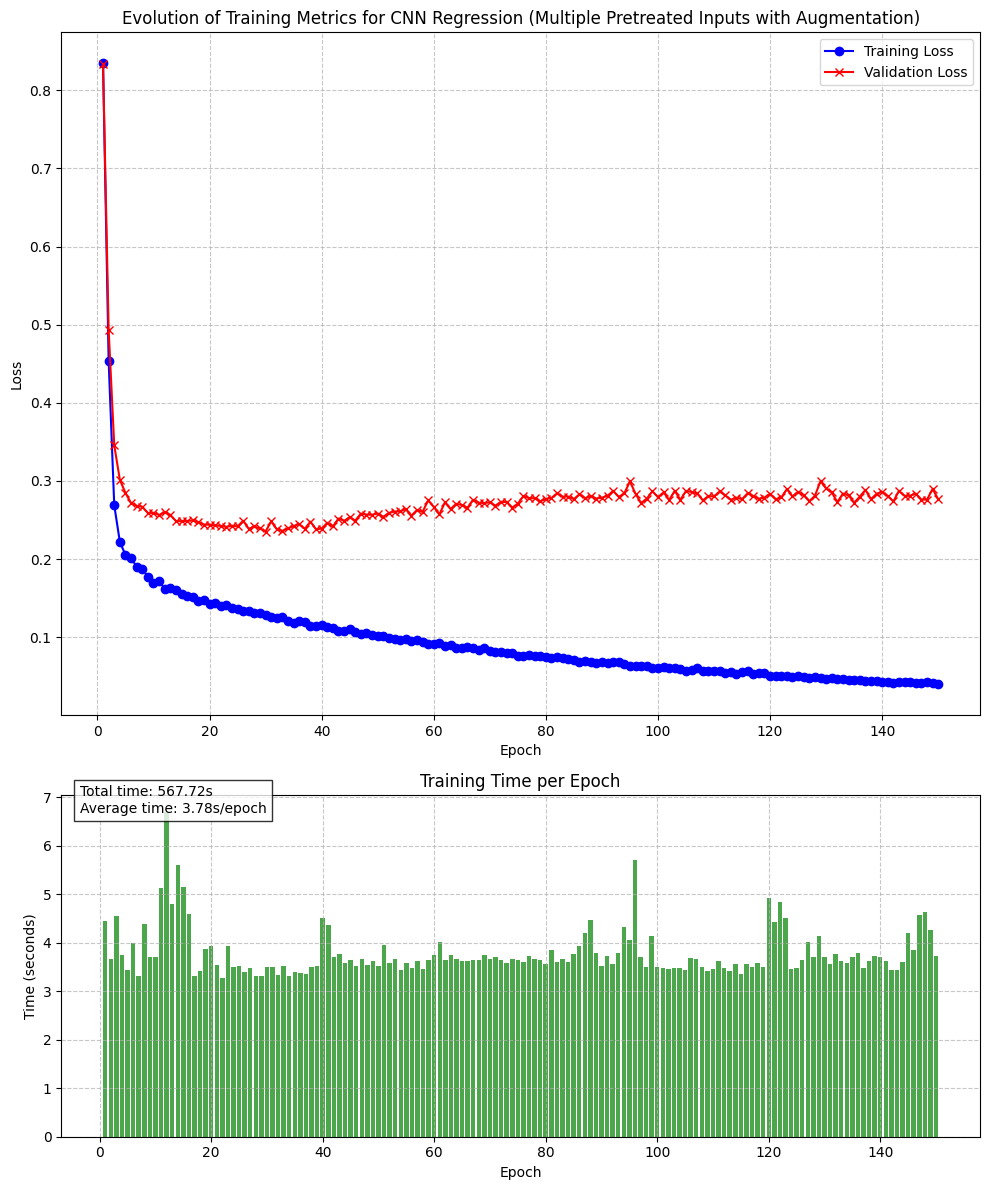

In [25]:

# Print evaluation metrics
print_regression_metrics(test_targets, test_predictions, "test")

# Visualize the evolution of metrics
plot_regression_metrics_sequence(
    metrics_history,
    title="Evolution of Training Metrics for CNN Regression (Multiple Pretreated Inputs with Augmentation)",
)

## Classification

### Shared encoding

In [59]:
# Encode the categorical target variable
label_encoder = LabelEncoder()
label_encoder.fit(data_3cl["num_classe"])
num_classes = len(label_encoder.classes_)

print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

Number of classes: 3
Classes: [1 2 3]


### Without pretreatments


In [26]:


# Custom Dataset class for our spectral data
class SpectralDataset(Dataset):
    """Dataset class to handle spectral data for PyTorch"""

    def __init__(self, X: np.ndarray | spmatrix, y: np.ndarray | spmatrix):
        # Reshape X for CNN input: [batch_size, channels, sequence_length]
        # For spectral data, we use 1 channel
        self.X = torch.FloatTensor(X).unsqueeze(1)  # Add channel dimension
        self.y = torch.LongTensor(y)  # LongTensor for classification targets

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.X[idx], self.y[idx]


# CNN model for classification
class CNNModel(nn.Module):
    """CNN model with two convolutional layers for spectral data classification

    Args:
        input_dim: Length of the spectral sequence
        output_dim: Number of classes for classification
    """

    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        kernel_size: int = KERNEL_SIZE,
        stride: int = STRIDE,
        padding: int = PADDING,
    ):
        super().__init__()

        # Calculate output size of first conv layer
        conv1_output_size = ((input_dim + 2 * padding - kernel_size) // stride) + 1

        # Calculate output size after pooling
        pool1_output_size = conv1_output_size // 2

        # Calculate output size of second conv layer
        conv2_output_size = (
            (pool1_output_size + 2 * padding - kernel_size) // stride
        ) + 1

        # Calculate output size after pooling
        pool2_output_size = conv2_output_size // 2

        # First convolutional layer: in_channels=1 (grayscale), out_channels=16
        self.conv1 = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=16,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # Second convolutional layer: in_channels=16, out_channels=32
        self.conv2 = nn.Sequential(
            nn.Conv1d(
                in_channels=16,
                out_channels=32,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # Final output is a flattened tensor of size (batch_size, 32 * pool2_output_size)
        # Fully connected layers for classification
        self.fc = nn.Sequential(
            nn.Linear(32 * pool2_output_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),  # Prevent overfitting
            nn.Linear(64, output_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Shape: (batch_size, 1, sequence_length)
        x = self.conv1(x)
        # Shape: (batch_size, 16, sequence_length/2)
        x = self.conv2(x)
        # Shape: (batch_size, 32, sequence_length/4)

        # Flatten: (batch_size, 32 * sequence_length/4)
        x = x.view(x.size(0), -1)

        # Output: (batch_size, output_dim)
        return self.fc(x)




#### Without data augmentation

##### Data preparation

In [75]:
# Preparing data for classification
indices = np.arange(len(data_3cl))
indices_train_temp, indices_test = train_test_split(
    indices,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=data_3cl["num_classe"],
)

indices_train, indices_val = train_test_split(
    indices_train_temp,
    test_size=VAL_SIZE,
    random_state=RANDOM_SEED,
    stratify=data_3cl.iloc[indices_train_temp]["num_classe"],
)

# Display set sizes
print(f"Training set: {len(indices_train)} samples")
print(f"Validation set: {len(indices_val)} samples")
print(f"Test set: {len(indices_test)} samples")

# Create datasets
train_data = data_3cl.iloc[indices_train].copy()
val_data = data_3cl.iloc[indices_val].copy()
test_data = data_3cl.iloc[indices_test].copy()


# Prepare features and targets for different sets
X_train_cls = np.array(train_data[spectral_cols])
y_train_cls = label_encoder.transform(train_data["num_classe"])

X_val_cls = np.array(val_data[spectral_cols])
y_val_cls = label_encoder.transform(val_data["num_classe"])

X_test_cls = np.array(test_data[spectral_cols])
y_test_cls = label_encoder.transform(test_data["num_classe"])

# Standardize features for classification
scaler_X_cls = StandardScaler()

X_train_cls = scaler_X_cls.fit_transform(X_train_cls)
X_val_cls = scaler_X_cls.transform(X_val_cls)
X_test_cls = scaler_X_cls.transform(X_test_cls)

# Create datasets and loaders for training and validation only
train_dataset = SpectralDataset(X_train_cls, y_train_cls)
val_dataset = SpectralDataset(X_val_cls, y_val_cls)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


Training set: 122 samples
Validation set: 31 samples
Test set: 51 samples


##### Model, criterion and optimizer

In [76]:

# Initialize model, loss function and optimizer
model = CNNModel(input_dim=len(spectral_cols), output_dim=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
summary(model)

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       64
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-4                       1,568
│    └─ReLU: 2-5                         --
│    └─MaxPool1d: 2-6                    --
├─Sequential: 1-3                        --
│    └─Linear: 2-7                       106,560
│    └─ReLU: 2-8                         --
│    └─Dropout: 2-9                      --
│    └─Linear: 2-10                      195
Total params: 108,387
Trainable params: 108,387
Non-trainable params: 0

##### Main loop

In [77]:

# Training loop
best_val_loss = float("inf")
best_model_state = None

# List to store training metrics
metrics_history: List[ClassificationMetrics] = []

print("Starting CNN training for classification without augmentation...")
total_training_start = time.time()
for epoch in range(N_EPOCHS):
    epoch_start = time.time()
    # Set model to training mode
    model.train()
    # Initialize the total training loss for this epoch
    train_loss = 0.0
    # Iterate over mini-batches of training data
    for X_batch, y_batch in train_loader:
        # Reset gradients to zero before computing new gradients
        optimizer.zero_grad()
        # Forward pass: compute model predictions
        outputs = model(X_batch)
        # Compute the loss between predictions and true values
        loss = criterion(outputs, y_batch)
        # Backward pass: compute gradients of the loss
        loss.backward()
        # Update model parameters using the optimizer
        optimizer.step()
        # Accumulate the batch loss
        train_loss += loss.item()

    # Validation phase
    model.eval()
    # Initialize the total validation loss for this epoch
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    # Disable gradient computation for validation
    with torch.no_grad():
        # Iterate over mini-batches of validation data
        for X_batch, y_batch in val_loader:
            # Forward pass only
            outputs = model(X_batch)
            # Accumulate the validation loss
            val_loss += criterion(outputs, y_batch).item()
            
             # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    # Calculate epoch execution time
    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start

    # Store metrics for each epoch
    metrics_history.append(
        ClassificationMetrics(
            epoch=epoch + 1,
            train_loss=avg_train_loss,
            val_loss=avg_val_loss,
            val_accuracy=val_accuracy,
            epoch_time=epoch_time,
        )
    )
    

    # Keep track of the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()

    # Print metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{N_EPOCHS}]")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Epoch Time: {epoch_time:.2f}s")
        print("-" * 50)

total_training_end = time.time()
total_training_time = total_training_end - total_training_start
print(f"Total training time: {total_training_time:.2f} seconds")
print(f"Average time per epoch: {total_training_time/N_EPOCHS:.2f} seconds")

# Load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(
        f"Best model loaded with validation loss of {best_val_loss/len(val_loader):.4f}"
    )

# Evaluation on test set
model.eval()
with torch.no_grad():
    # Convert test data to tensors directly
    X_test_tensor = torch.FloatTensor(X_test_cls).unsqueeze(1)  # Add channel dimension
    y_test_tensor = torch.LongTensor(y_test_cls)

    # Get predictions for all test data at once
    test_logits = model(X_test_tensor)
    test_predictions = torch.argmax(test_logits, dim=1).detach().numpy()
    test_targets = y_test_tensor.detach().numpy()


Starting CNN training for classification without augmentation...
Epoch [10/150]
Train Loss: 1.0575
Val Loss: 1.0601
Epoch Time: 0.05s
--------------------------------------------------
Epoch [20/150]
Train Loss: 1.0278
Val Loss: 1.0354
Epoch Time: 0.08s
--------------------------------------------------
Epoch [30/150]
Train Loss: 0.9970
Val Loss: 1.0082
Epoch Time: 0.04s
--------------------------------------------------
Epoch [40/150]
Train Loss: 0.9662
Val Loss: 0.9800
Epoch Time: 0.05s
--------------------------------------------------
Epoch [50/150]
Train Loss: 0.9399
Val Loss: 0.9537
Epoch Time: 0.04s
--------------------------------------------------
Epoch [60/150]
Train Loss: 0.9079
Val Loss: 0.9288
Epoch Time: 0.05s
--------------------------------------------------
Epoch [70/150]
Train Loss: 0.8818
Val Loss: 0.9041
Epoch Time: 0.04s
--------------------------------------------------
Epoch [80/150]
Train Loss: 0.8671
Val Loss: 0.8806
Epoch Time: 0.06s
--------------------------

##### Conclusion


Metrics for test set:
Accuracy: 0.6667
Balanced Accuracy: 0.3333

Confusion Matrix:
[[34  0  0]
 [ 7  0  0]
 [10  0  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        34
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        10

    accuracy                           0.67        51
   macro avg       0.22      0.33      0.27        51
weighted avg       0.44      0.67      0.53        51



c:\Users\Guilhem\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Guilhem\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Guilhem\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

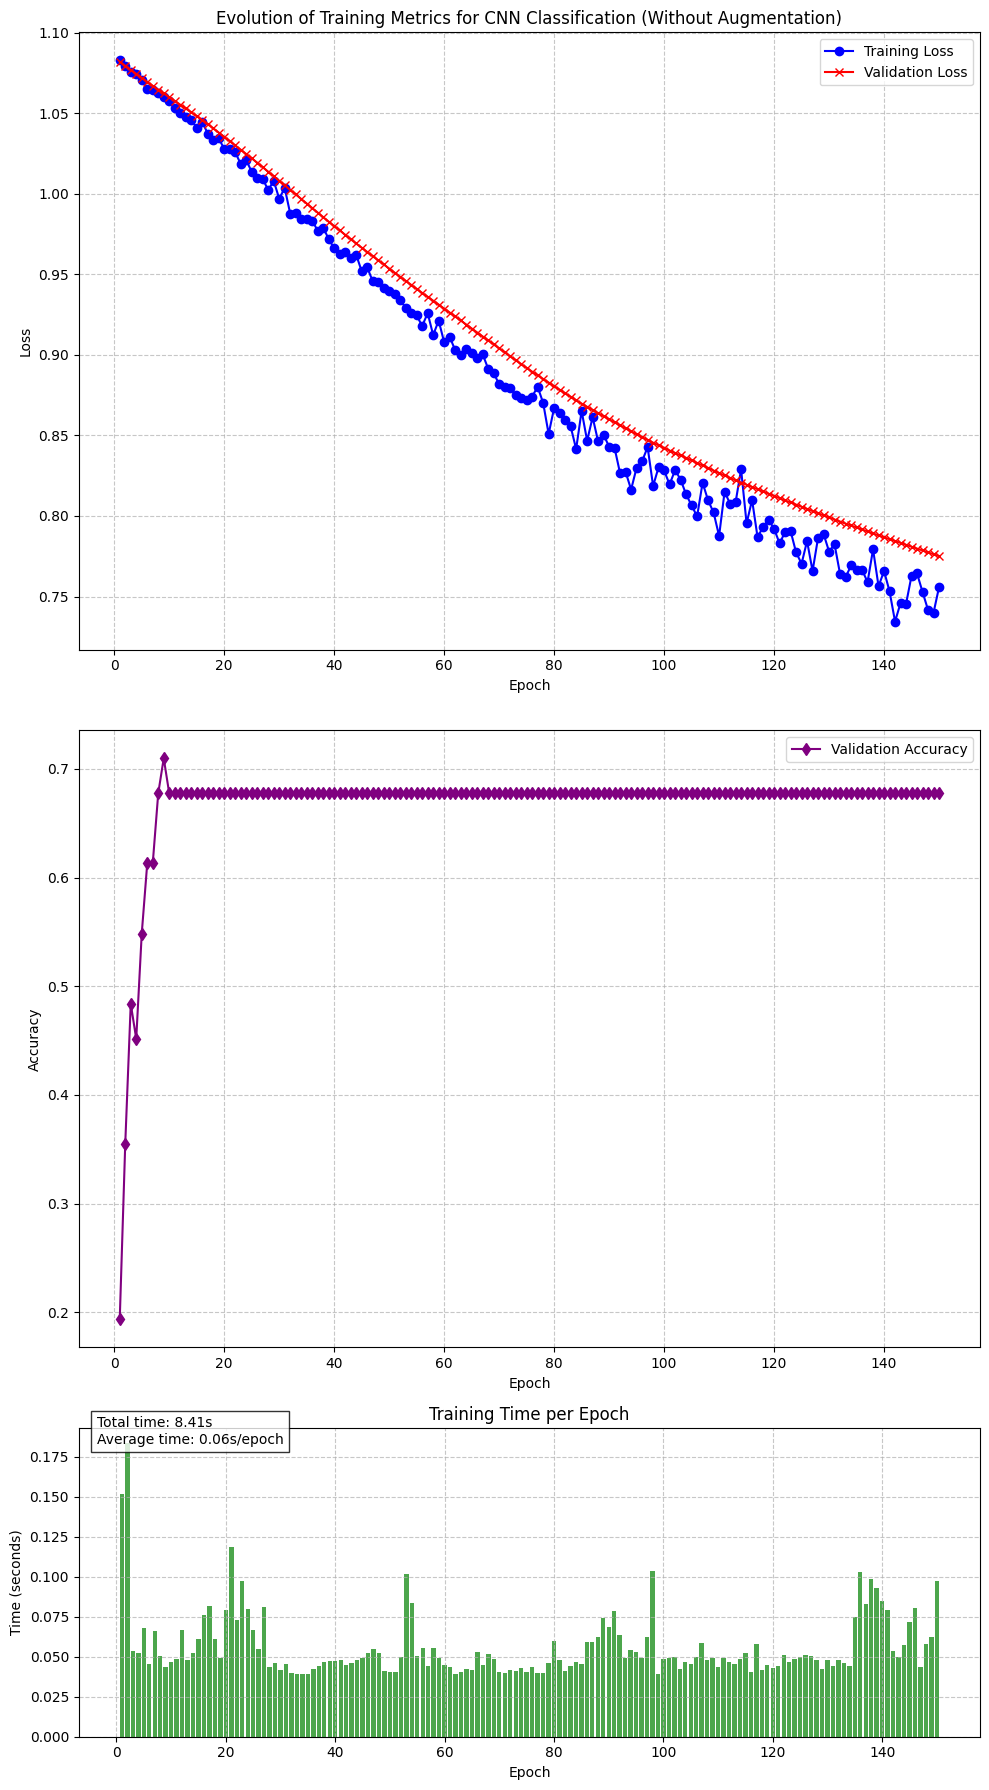

In [78]:

# Print evaluation metrics
print_classification_metrics(test_targets, test_predictions, "test")

# Visualize the evolution of metrics
plot_classification_metrics_sequence(
    metrics_history,
    title="Evolution of Training Metrics for CNN Classification (Without Augmentation)")

#### With data augmentation

##### Data preparation

In [79]:
# Re-use the same train-test-validation split
train_data = data_3cl.iloc[indices_train].copy()
val_data = data_3cl.iloc[indices_val].copy()
test_data = data_3cl.iloc[indices_test].copy()

# Create augmentation parameters
augmentation_params = AugmentationParams(
    mixup_alpha=0.4,  # Higher alpha for more diverse mixing
    gaussian_noise_std=0.03,  # Increased noise for better robustness
    jitter_factor=0.04,  # More intensity variation
    augmentation_probability=0.8,  # Higher probability of applying augmentation
    by=[
        "symptom",
        "variety",
        "plotLocation",
        "num_classe",
    ],  # Group by these columns, including class
    batch_size=100,  # Generate 100 samples per group
    exclude_columns=None,  # Don't exclude any columns to keep all spectral data
)

# Create augmenter and augment training data
augmenter = DataAugmenter(augmentation_params)
train_data_augmented = augmenter.augment(train_data)

print(f"Training set (original): {len(train_data)} samples")
print(f"Training set (after augmentation): {len(train_data_augmented)} samples")
print(f"Validation set: {len(val_data)} samples")
print(f"Test set: {len(test_data)} samples")

# Prepare features and targets for different sets with augmented data
X_train_cls = np.array(train_data_augmented[spectral_cols])
y_train_cls = label_encoder.transform(train_data_augmented["num_classe"])

X_val_cls = np.array(val_data[spectral_cols])
y_val_cls = label_encoder.transform(val_data["num_classe"])

X_test_cls = np.array(test_data[spectral_cols])
y_test_cls = label_encoder.transform(test_data["num_classe"])

# Standardize features for classification
scaler_X_cls = StandardScaler()

X_train_cls = scaler_X_cls.fit_transform(X_train_cls)
X_val_cls = scaler_X_cls.transform(X_val_cls)
X_test_cls = scaler_X_cls.transform(X_test_cls)

# Create datasets and loaders for training and validation only
train_dataset = SpectralDataset(X_train_cls, y_train_cls)
val_dataset = SpectralDataset(X_val_cls, y_val_cls)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


C:\Users\Guilhem\code\SUPAGRO\hyperspectral-analysis\src\data_augmenter.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_df in df.groupby(self.params.by):
C:\Users\Guilhem\code\SUPAGRO\hyperspectral-analysis\src\data_augmenter.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_df in df.groupby(self.params.by):
C:\Users\Guilhem\code\SUPAGRO\hyperspectral-analysis\src\data_augmenter.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

Training set (original): 122 samples
Training set (after augmentation): 4000 samples
Validation set: 31 samples
Test set: 51 samples


##### Model, criterion and optimizer

In [80]:

# Initialize model, loss function and optimizer
model_aug = CNNModel(input_dim=len(spectral_cols), output_dim=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.parameters(), lr=LEARNING_RATE)
summary(model_aug)


Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       64
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-4                       1,568
│    └─ReLU: 2-5                         --
│    └─MaxPool1d: 2-6                    --
├─Sequential: 1-3                        --
│    └─Linear: 2-7                       106,560
│    └─ReLU: 2-8                         --
│    └─Dropout: 2-9                      --
│    └─Linear: 2-10                      195
Total params: 108,387
Trainable params: 108,387
Non-trainable params: 0

##### Main loop

In [86]:


# Training loop
best_val_loss = float("inf")
best_model_state = None

# List to store training metrics
metrics_history: List[ClassificationMetrics] = []

print("Starting CNN training for classification with augmentation...")
total_training_start = time.time()
for epoch in range(N_EPOCHS):
    epoch_start = time.time()
    # Set model to training mode
    model_aug.train()
    # Initialize the total training loss for this epoch
    train_loss = 0.0
    # Iterate over mini-batches of training data
    for X_batch, y_batch in train_loader:
        # Reset gradients to zero before computing new gradients
        optimizer.zero_grad()
        # Forward pass: compute model predictions
        outputs = model_aug(X_batch)
        # Compute the loss between predictions and true values
        loss = criterion(outputs, y_batch)
        # Backward pass: compute gradients of the loss
        loss.backward()
        # Update model parameters using the optimizer
        optimizer.step()
        # Accumulate the batch loss
        train_loss += loss.item()

    # Validation phase
    model_aug.eval()
    # Initialize the total validation loss for this epoch
    val_loss = 0.0
    # Disable gradient computation for validation
    with torch.no_grad():
        # Iterate over mini-batches of validation data
        for X_batch, y_batch in val_loader:
            # Forward pass only
            outputs = model_aug(X_batch)
            # Accumulate the validation loss
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            print(loss.item())
             # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    # Calculate epoch execution time
    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start

    # Store metrics for each epoch
    metrics_history.append(
        ClassificationMetrics(
            epoch=epoch + 1,
            train_loss=avg_train_loss,
            val_loss=avg_val_loss,
            val_accuracy=val_accuracy,
            epoch_time=epoch_time,
        )
    )

    # Keep track of the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model_aug.state_dict().copy()

    # Print metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{N_EPOCHS}]")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Epoch Time: {epoch_time:.2f}s")
        print("-" * 50)

total_training_end = time.time()
total_training_time = total_training_end - total_training_start
print(f"Total training time: {total_training_time:.2f} seconds")
print(f"Average time per epoch: {total_training_time/N_EPOCHS:.2f} seconds")

# Load the best model
if best_model_state is not None:
    model_aug.load_state_dict(best_model_state)
    print(
        f"Best model loaded with validation loss of {best_val_loss/len(val_loader):.4f}"
    )

# Evaluation on test set
model_aug.eval()
with torch.no_grad():
    # Convert test data to tensors directly
    X_test_tensor = torch.FloatTensor(X_test_cls).unsqueeze(1)  # Add channel dimension
    y_test_tensor = torch.LongTensor(y_test_cls)

    # Get predictions for all test data at once
    test_logits = model_aug(X_test_tensor)
    test_predictions = torch.argmax(test_logits, dim=1).detach().numpy()
    test_targets = y_test_tensor.detach().numpy()


Starting CNN training for classification with augmentation...
1.1926199197769165
1.2004567384719849
1.2018088102340698
1.2126997709274292
1.2188831567764282
1.2167807817459106
1.2194777727127075
1.2113351821899414
1.20772385597229
1.2180649042129517
Epoch [10/150]
Train Loss: 0.0935
Val Loss: 1.2181
Epoch Time: 1.46s
--------------------------------------------------
1.21626877784729
1.226934790611267
1.2185457944869995
1.2258095741271973
1.2250056266784668
1.218727946281433
1.2295578718185425
1.238336443901062
1.2586015462875366
1.230617880821228
Epoch [20/150]
Train Loss: 0.0949
Val Loss: 1.2306
Epoch Time: 1.30s
--------------------------------------------------
1.240746259689331
1.254742980003357
1.256932020187378
1.2495942115783691
1.2645765542984009
1.2561277151107788
1.2539867162704468
1.2746860980987549
1.264587163925171
1.2727798223495483
Epoch [30/150]
Train Loss: 0.0875
Val Loss: 1.2728
Epoch Time: 1.33s
--------------------------------------------------
1.2707668542861938
1

##### Conclusion


Metrics for test set:
Accuracy: 0.7647
Balanced Accuracy: 0.6513

Confusion Matrix:
[[30  3  1]
 [ 2  4  1]
 [ 3  2  5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        34
           1       0.44      0.57      0.50         7
           2       0.71      0.50      0.59        10

    accuracy                           0.76        51
   macro avg       0.67      0.65      0.65        51
weighted avg       0.77      0.76      0.76        51



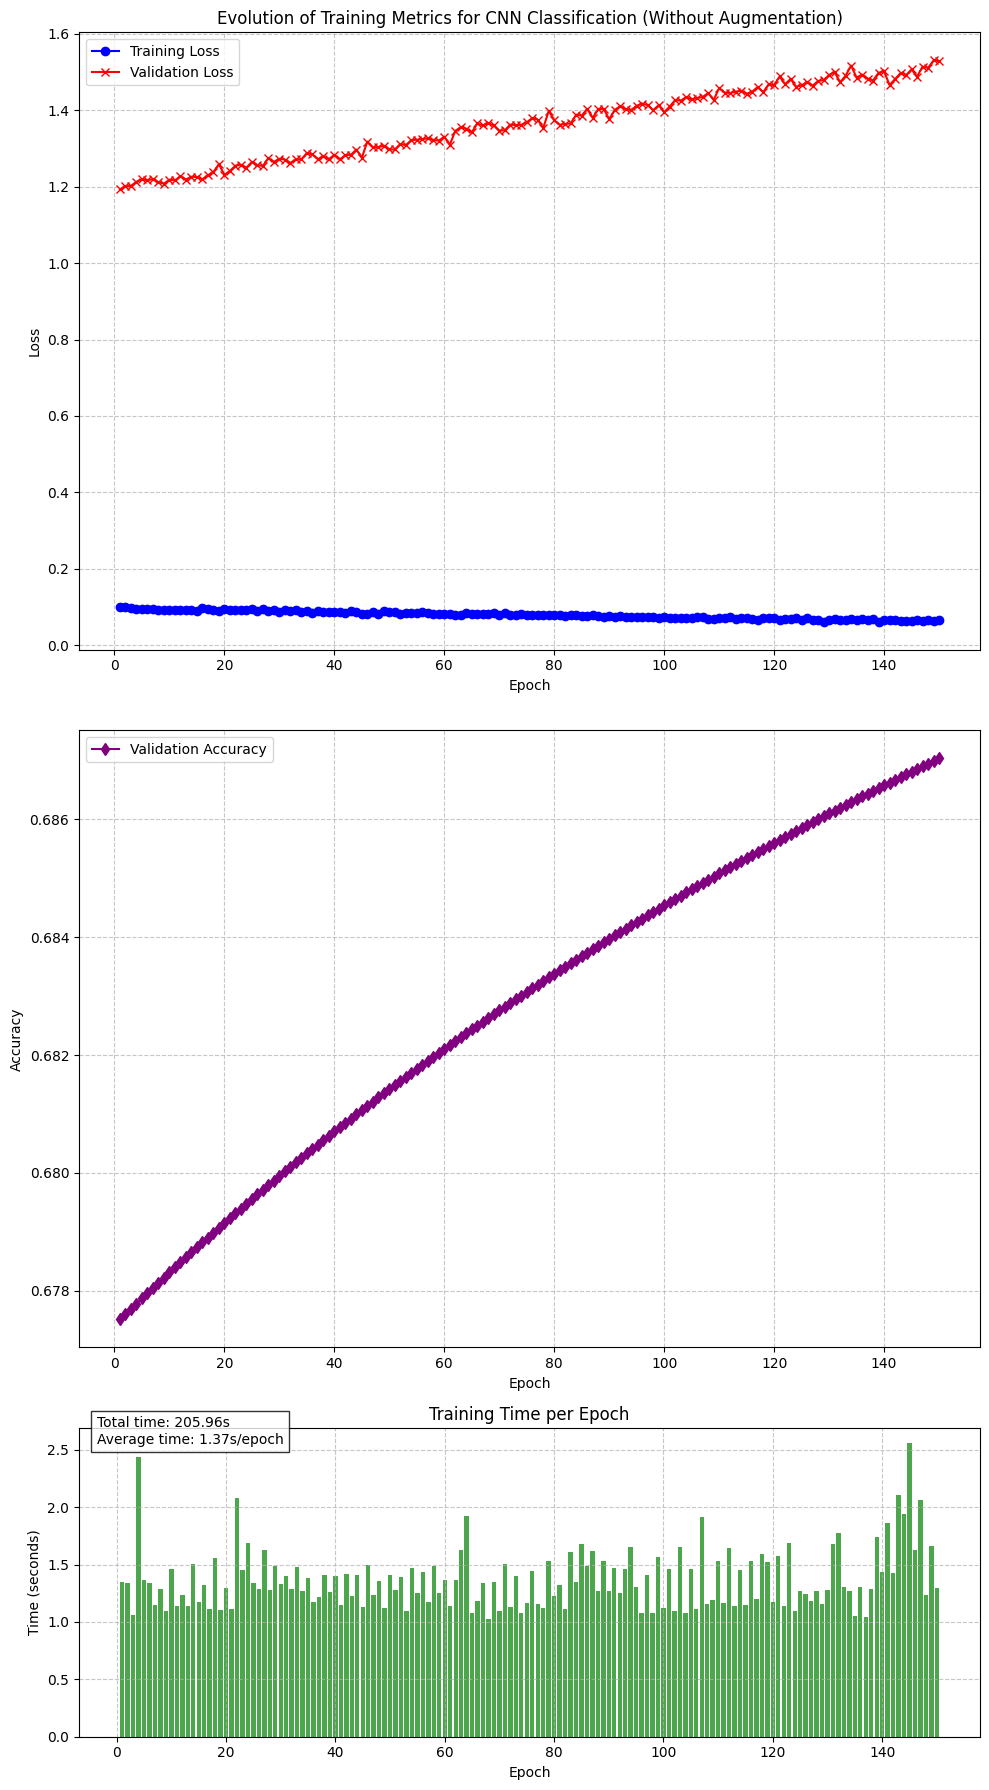

In [87]:

# Print evaluation metrics
print_classification_metrics(test_targets, test_predictions, "test")

# Visualize the evolution of metrics
plot_classification_metrics_sequence(
    metrics_history,
    title="Evolution of Training Metrics for CNN Classification (Without Augmentation)")

#### Comparaison

c:\Users\Guilhem\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Guilhem\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Guilhem\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Accuracy (standard): 0.6667
Accuracy (augmented): 0.7647
Improvement: 14.71%

Precision (standard): 0.2222
Precision (augmented): 0.6720
Improvement: 202.38%

Recall (standard): 0.3333
Recall (augmented): 0.6513
Improvement: 95.38%

F1 Score (standard): 0.2667
F1 Score (augmented): 0.6526
Improvement: 144.73%

Classification Report (Standard Model):
              precision    recall  f1-score   support

           0     0.6667    1.0000    0.8000        34
           1     0.0000    0.0000    0.0000         7
           2     0.0000    0.0000    0.0000        10

    accuracy                         0.6667        51
   macro avg     0.2222    0.3333    0.2667        51
weighted avg     0.4444    0.6667    0.5333        51


Classification Report (Augmented Model):
              precision    recall  f1-score   support

           0     0.8571    0.8824    0.8696        34
           1     0.4444    0.5714    0.5000         7
           2     0.7143    0.5000    0.5882        10

    acc

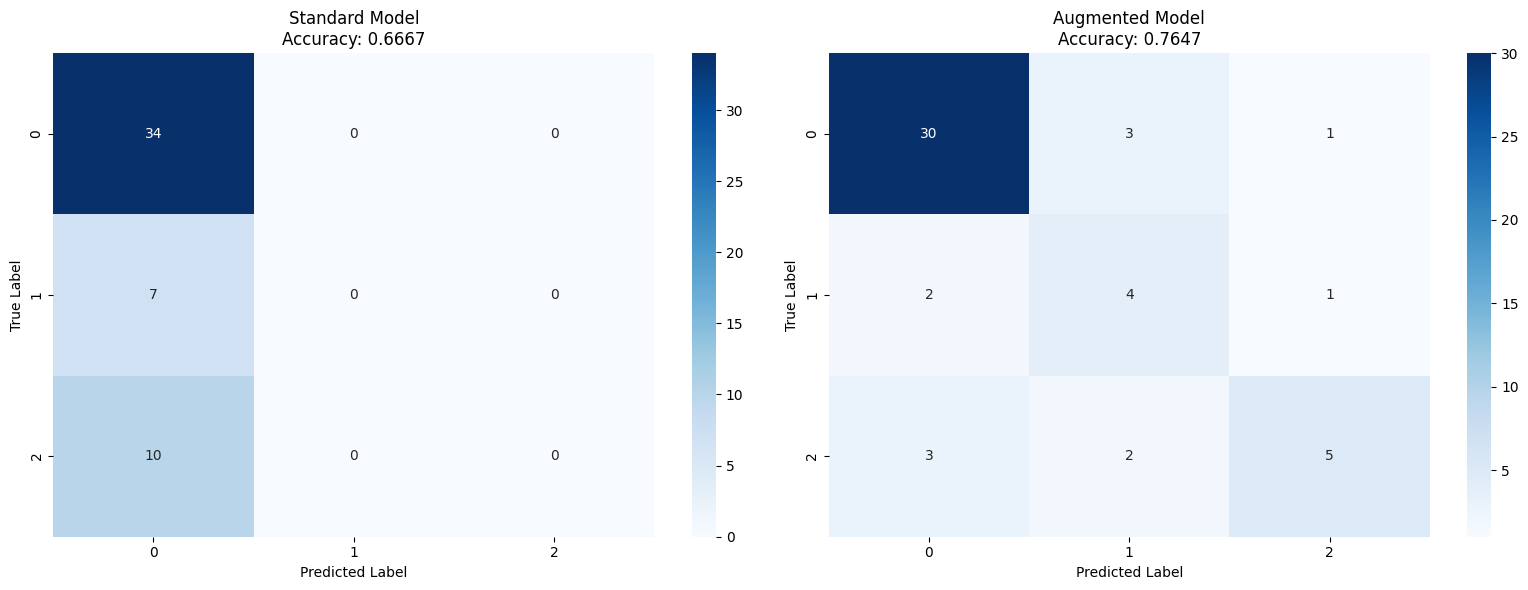

In [88]:

model.eval()
model_aug.eval()

with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test_cls).unsqueeze(1)

    # Get predictions from both models
    test_logits_standard = model(X_test_tensor)
    test_logits_augmented = model_aug(X_test_tensor)

    test_pred_standard = torch.argmax(test_logits_standard, dim=1).detach().numpy()
    test_pred_augmented = torch.argmax(test_logits_augmented, dim=1).detach().numpy()

# Calculate metrics for both models
accuracy_standard = accuracy_score(test_targets, test_pred_standard)
accuracy_augmented = accuracy_score(test_targets, test_pred_augmented)

precision_standard = precision_score(test_targets, test_pred_standard, average="macro")
precision_augmented = precision_score(
    test_targets, test_pred_augmented, average="macro"
)

recall_standard = recall_score(test_targets, test_pred_standard, average="macro")
recall_augmented = recall_score(test_targets, test_pred_augmented, average="macro")

f1_standard = f1_score(test_targets, test_pred_standard, average="macro")
f1_augmented = f1_score(test_targets, test_pred_augmented, average="macro")

# Print comparison
print(f"Accuracy (standard): {accuracy_standard:.4f}")
print(f"Accuracy (augmented): {accuracy_augmented:.4f}")
print(
    f"Improvement: {(accuracy_augmented - accuracy_standard) / accuracy_standard * 100:.2f}%"
)
print()

print(f"Precision (standard): {precision_standard:.4f}")
print(f"Precision (augmented): {precision_augmented:.4f}")
print(
    f"Improvement: {(precision_augmented - precision_standard) / precision_standard * 100:.2f}%"
)
print()

print(f"Recall (standard): {recall_standard:.4f}")
print(f"Recall (augmented): {recall_augmented:.4f}")
print(
    f"Improvement: {(recall_augmented - recall_standard) / recall_standard * 100:.2f}%"
)
print()

print(f"F1 Score (standard): {f1_standard:.4f}")
print(f"F1 Score (augmented): {f1_augmented:.4f}")
print(f"Improvement: {(f1_augmented - f1_standard) / f1_standard * 100:.2f}%")

# Print classification reports for both models
print("\nClassification Report (Standard Model):")
cls_report_standard = classification_report(test_targets, test_pred_standard, digits=4)
print(cls_report_standard)

print("\nClassification Report (Augmented Model):")
cls_report_augmented = classification_report(
    test_targets, test_pred_augmented, digits=4
)
print(cls_report_augmented)

# Visualize confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot confusion matrix for standard model
cm_standard = confusion_matrix(test_targets, test_pred_standard)
sns.heatmap(cm_standard, annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title(f"Standard Model\nAccuracy: {accuracy_standard:.4f}")
ax1.set_ylabel("True Label")
ax1.set_xlabel("Predicted Label")

# Plot confusion matrix for augmented model
cm_augmented = confusion_matrix(test_targets, test_pred_augmented)
sns.heatmap(cm_augmented, annot=True, fmt="d", cmap="Blues", ax=ax2)
ax2.set_title(f"Augmented Model\nAccuracy: {accuracy_augmented:.4f}")
ax2.set_ylabel("True Label")
ax2.set_xlabel("Predicted Label")

plt.tight_layout()
plt.show()

Acuracy differences doesn't seems big, but the other metrics are particuraly  different. Be careful about the metric used !

### With Pretreatment

In [89]:
# CNN model with multiple inputs for regression
class MultiInputCNNModel(nn.Module):
    """CNN model with parallel paths for multiple spectral transformations

    Args:
        input_dim: Length of the spectral sequence
        output_dim: Number of outputs (1 for single value regression)
    """

    def __init__(
        self,
        input_dim: int,
        output_dim: int = 1,
        kernel_size: int = KERNEL_SIZE,
        stride: int = STRIDE,
        padding: int = PADDING,
    ):
        super().__init__()

        # Calculate output size of first conv layer
        conv1_output_size = ((input_dim + 2 * padding - kernel_size) // stride) + 1

        # Calculate output size after pooling
        pool1_output_size = conv1_output_size // 2

        # Calculate output size of second conv layer
        conv2_output_size = (
            (pool1_output_size + 2 * padding - kernel_size) // stride
        ) + 1

        # Calculate output size after pooling
        pool2_output_size = conv2_output_size // 2

        # Define CNN path for original spectral data
        self.cnn_original = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=16,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(
                in_channels=16,
                out_channels=32,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # Define CNN path for SNV + Savitzky-Golay transformed data
        self.cnn_snv_sg = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=16,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(
                in_channels=16,
                out_channels=32,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # Define CNN path for first derivative transformed data
        self.cnn_deriv1 = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=16,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(
                in_channels=16,
                out_channels=32,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # Define CNN path for second derivative transformed data
        self.cnn_deriv2 = nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=16,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(
                in_channels=16,
                out_channels=32,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # Calculate total features after concatenation
        total_features = 32 * pool2_output_size * 4  # 4 paths

        # Fully connected layers that combine all paths for regression
        self.fc = nn.Sequential(
            nn.Linear(total_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),  # Prevent overfitting
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_dim),
        )

    def forward(self, x_list: list[torch.Tensor]) -> torch.Tensor:
        # Process each input through its respective CNN path
        x_original = self.cnn_original(x_list[0])
        x_snv_sg = self.cnn_snv_sg(x_list[1])
        x_deriv1 = self.cnn_deriv1(x_list[2])
        x_deriv2 = self.cnn_deriv2(x_list[3])

        # Flatten each output
        x_original = x_original.view(x_original.size(0), -1)
        x_snv_sg = x_snv_sg.view(x_snv_sg.size(0), -1)
        x_deriv1 = x_deriv1.view(x_deriv1.size(0), -1)
        x_deriv2 = x_deriv2.view(x_deriv2.size(0), -1)

        # Concatenate all flattened outputs
        x_combined = torch.cat([x_original, x_snv_sg, x_deriv1, x_deriv2], dim=1)

        # Pass through fully connected layers
        return self.fc(x_combined)


# Custom Dataset class for spectral data with multiple transformations
class MultiSpectralDataset(Dataset):
    """Dataset class to handle multiple spectral data transformations for PyTorch"""

    def __init__(
        self,
        X_original: np.ndarray | spmatrix,
        X_snv_sg: np.ndarray | spmatrix,
        X_deriv1: np.ndarray | spmatrix,
        X_deriv2: np.ndarray | spmatrix,
        y: np.ndarray | spmatrix,
    ):
        # Reshape each X for CNN input: [batch_size, channels, sequence_length]
        self.X_original = torch.FloatTensor(X_original).unsqueeze(
            1
        )  # Add channel dimension
        self.X_snv_sg = torch.FloatTensor(X_snv_sg).unsqueeze(1)
        self.X_deriv1 = torch.FloatTensor(X_deriv1).unsqueeze(1)
        self.X_deriv2 = torch.FloatTensor(X_deriv2).unsqueeze(1)
        self.y = torch.FloatTensor(y)  # FloatTensor for regression targets

    def __len__(self) -> int:
        return len(self.X_original)

    def __getitem__(self, idx: int) -> tuple[list[torch.Tensor], torch.Tensor]:
        return [
            self.X_original[idx],
            self.X_snv_sg[idx],
            self.X_deriv1[idx],
            self.X_deriv2[idx],
        ], self.y[idx]



#### Without Data augmentation

##### Data preparation

In [90]:
# Preparing data for regression
indices = np.arange(len(data_3cl))
indices_train_temp, indices_test = train_test_split(
    indices, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

indices_train, indices_val = train_test_split(
    indices_train_temp, test_size=VAL_SIZE, random_state=RANDOM_SEED
)

# Display set sizes
print(f"Training set: {len(indices_train)} samples")
print(f"Validation set: {len(indices_val)} samples")
print(f"Test set: {len(indices_test)} samples")

# Create datasets
train_data = data_3cl.iloc[indices_train].copy()
val_data = data_3cl.iloc[indices_val].copy()
test_data = data_3cl.iloc[indices_test].copy()

# Prepare features and targets for different sets
# Get original spectral data
X_train_original = np.array(train_data[spectral_cols])
X_val_original = np.array(val_data[spectral_cols])
X_test_original = np.array(test_data[spectral_cols])

# Get SNV+SG transformed data
X_train_snv_sg = np.array(mat_snv_sg_3cl.iloc[indices_train][spectral_cols])
X_val_snv_sg = np.array(mat_snv_sg_3cl.iloc[indices_val][spectral_cols])
X_test_snv_sg = np.array(mat_snv_sg_3cl.iloc[indices_test][spectral_cols])

# Get first derivative transformed data
X_train_deriv1 = np.array(mat_deriv1_3cl.iloc[indices_train][spectral_cols])
X_val_deriv1 = np.array(mat_deriv1_3cl.iloc[indices_val][spectral_cols])
X_test_deriv1 = np.array(mat_deriv1_3cl.iloc[indices_test][spectral_cols])

# Get second derivative transformed data
X_train_deriv2 = np.array(mat_deriv2_3cl.iloc[indices_train][spectral_cols])
X_val_deriv2 = np.array(mat_deriv2_3cl.iloc[indices_val][spectral_cols])
X_test_deriv2 = np.array(mat_deriv2_3cl.iloc[indices_test][spectral_cols])

# Standardize each spectral dataset
scaler_original = StandardScaler()
scaler_snv_sg = StandardScaler()
scaler_deriv1 = StandardScaler()
scaler_deriv2 = StandardScaler()
scaler_y_Chl = StandardScaler()

# Scale original spectral data
X_train_original = scaler_original.fit_transform(X_train_original)
X_val_original = scaler_original.transform(X_val_original)
X_test_original = scaler_original.transform(X_test_original)

# Scale SNV+SG transformed data
X_train_snv_sg = scaler_snv_sg.fit_transform(X_train_snv_sg)
X_val_snv_sg = scaler_snv_sg.transform(X_val_snv_sg)
X_test_snv_sg = scaler_snv_sg.transform(X_test_snv_sg)

# Scale first derivative transformed data
X_train_deriv1 = scaler_deriv1.fit_transform(X_train_deriv1)
X_val_deriv1 = scaler_deriv1.transform(X_val_deriv1)
X_test_deriv1 = scaler_deriv1.transform(X_test_deriv1)

# Scale second derivative transformed data
X_train_deriv2 = scaler_deriv2.fit_transform(X_train_deriv2)
X_val_deriv2 = scaler_deriv2.transform(X_val_deriv2)
X_test_deriv2 = scaler_deriv2.transform(X_test_deriv2)

# Prepare features and targets for different sets with augmented data
y_train_cls = label_encoder.transform(train_data["num_classe"])
y_val_cls = label_encoder.transform(val_data["num_classe"])
y_test_cls = label_encoder.transform(test_data["num_classe"])


# Create datasets and loaders for training and validation
train_dataset = MultiSpectralDataset(
    X_train_original, X_train_snv_sg, X_train_deriv1, X_train_deriv2, y_train_chl
)
val_dataset = MultiSpectralDataset(
    X_val_original, X_val_snv_sg, X_val_deriv1, X_val_deriv2, y_val_chl
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)



Training set: 122 samples
Validation set: 31 samples
Test set: 51 samples


##### Model, criterion and optimizer

In [91]:


# Initialize model, loss function and optimizer
model = MultiInputCNNModel(input_dim=len(spectral_cols))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
summary(model)


Layer (type:depth-idx)                   Param #
MultiInputCNNModel                       --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       64
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
│    └─Conv1d: 2-4                       1,568
│    └─ReLU: 2-5                         --
│    └─MaxPool1d: 2-6                    --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-7                       64
│    └─ReLU: 2-8                         --
│    └─MaxPool1d: 2-9                    --
│    └─Conv1d: 2-10                      1,568
│    └─ReLU: 2-11                        --
│    └─MaxPool1d: 2-12                   --
├─Sequential: 1-3                        --
│    └─Conv1d: 2-13                      64
│    └─ReLU: 2-14                        --
│    └─MaxPool1d: 2-15                   --
│    └─Conv1d: 2-16                      1,568
│    └─ReLU: 2-17                        --
│    └─MaxPool1d: 

##### Main loop

In [93]:

# Training loop
best_val_loss = float("inf")
best_model_state = None

# List to store training metrics
metrics_history: List[ClassificationMetrics] = []

print("Starting CNN training for regression with preprocessing...")
total_training_start = time.time()
for epoch in range(N_EPOCHS):
    epoch_start = time.time()
    # Set model to training mode
    model.train()
    # Initialize the total training loss for this epoch
    train_loss = 0.0
    # Iterate over mini-batches of training data
    for X_batch, y_batch in train_loader:
        # Reset gradients to zero before computing new gradients
        optimizer.zero_grad()
        # Forward pass: compute model predictions
        outputs = model(X_batch)
        # Compute the loss between predictions and true values
        loss = criterion(outputs, y_batch)
        # Backward pass: compute gradients of the loss
        loss.backward()
        # Update model parameters using the optimizer
        optimizer.step()
        # Accumulate the batch loss
        train_loss += loss.item()

    # Validation phase
    model.eval()
    # Initialize the total validation loss for this epoch
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    # Disable gradient computation for validation
    with torch.no_grad():
        # Iterate over mini-batches of validation data
        for X_batch, y_batch in val_loader:

            # Forward pass only
            outputs = model(X_batch)
            # Accumulate the validation loss
            val_loss += criterion(outputs, y_batch).item()
            
             # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()
            print(y_batch)
            print(predicted)

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    # Calculate epoch execution time
    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start

    # Store metrics for each epoch
    metrics_history.append(
        ClassificationMetrics(
            epoch=epoch + 1,
            train_loss=avg_train_loss,
            val_loss=avg_val_loss,
            val_accuracy=val_accuracy,
            epoch_time=epoch_time,
        )
    )

    # Keep track of the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict().copy()

    # Print metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{N_EPOCHS}]")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Epoch Time: {epoch_time:.2f}s")
        print("-" * 50)

total_training_end = time.time()
total_training_time = total_training_end - total_training_start
print(f"Total training time: {total_training_time:.2f} seconds")
print(f"Average time per epoch: {total_training_time/N_EPOCHS:.2f} seconds")

# Load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(
        f"Best model loaded with validation loss of {best_val_loss/len(val_loader):.4f}"
    )

# Evaluation on test set
model.eval()
with torch.no_grad():
    # Create dataset for test data
    test_inputs = [
        torch.FloatTensor(X_test_original).unsqueeze(1),
        torch.FloatTensor(X_test_snv_sg).unsqueeze(1),
        torch.FloatTensor(X_test_deriv1).unsqueeze(1),
        torch.FloatTensor(X_test_deriv2).unsqueeze(1),
    ]
    test_targets = torch.FloatTensor(y_test_cls)

    # Get predictions for all test data at once
    test_logits = model(test_inputs)
    test_predictions = torch.argmax(test_logits, dim=1).detach().numpy()
    test_targets = y_test_tensor.detach().numpy()


Starting CNN training for regression with preprocessing...
tensor([[-1.5504],
        [ 0.3932],
        [ 0.0280],
        [ 1.8778],
        [ 0.3249],
        [-1.4607],
        [-1.6027],
        [ 1.3207],
        [ 0.3635],
        [-0.7223],
        [-1.2867],
        [-0.5167],
        [-0.0833],
        [ 2.2761],
        [-0.0045],
        [ 0.4168],
        [-0.9535],
        [-0.4063],
        [-0.2747],
        [-0.2293],
        [ 2.0092],
        [ 0.8339],
        [-0.6310],
        [-1.1989],
        [ 0.8972],
        [-0.6052],
        [-0.9320],
        [ 2.2544],
        [ 0.4897],
        [ 0.3172],
        [-0.0245]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0])
tensor([[-1.5504],
        [ 0.3932],
        [ 0.0280],
        [ 1.8778],
        [ 0.3249],
        [-1.4607],
        [-1.6027],
        [ 1.3207],
        [ 0.3635],
        [-0.7223],
        [-1.2867],
        [-0.5167],
        [-0.0

##### Conclusion


Metrics for test set:
Accuracy: 0.6667
Balanced Accuracy: 0.3333

Confusion Matrix:
[[34  0  0]
 [ 7  0  0]
 [10  0  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        34
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        10

    accuracy                           0.67        51
   macro avg       0.22      0.33      0.27        51
weighted avg       0.44      0.67      0.53        51



c:\Users\Guilhem\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Guilhem\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Guilhem\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

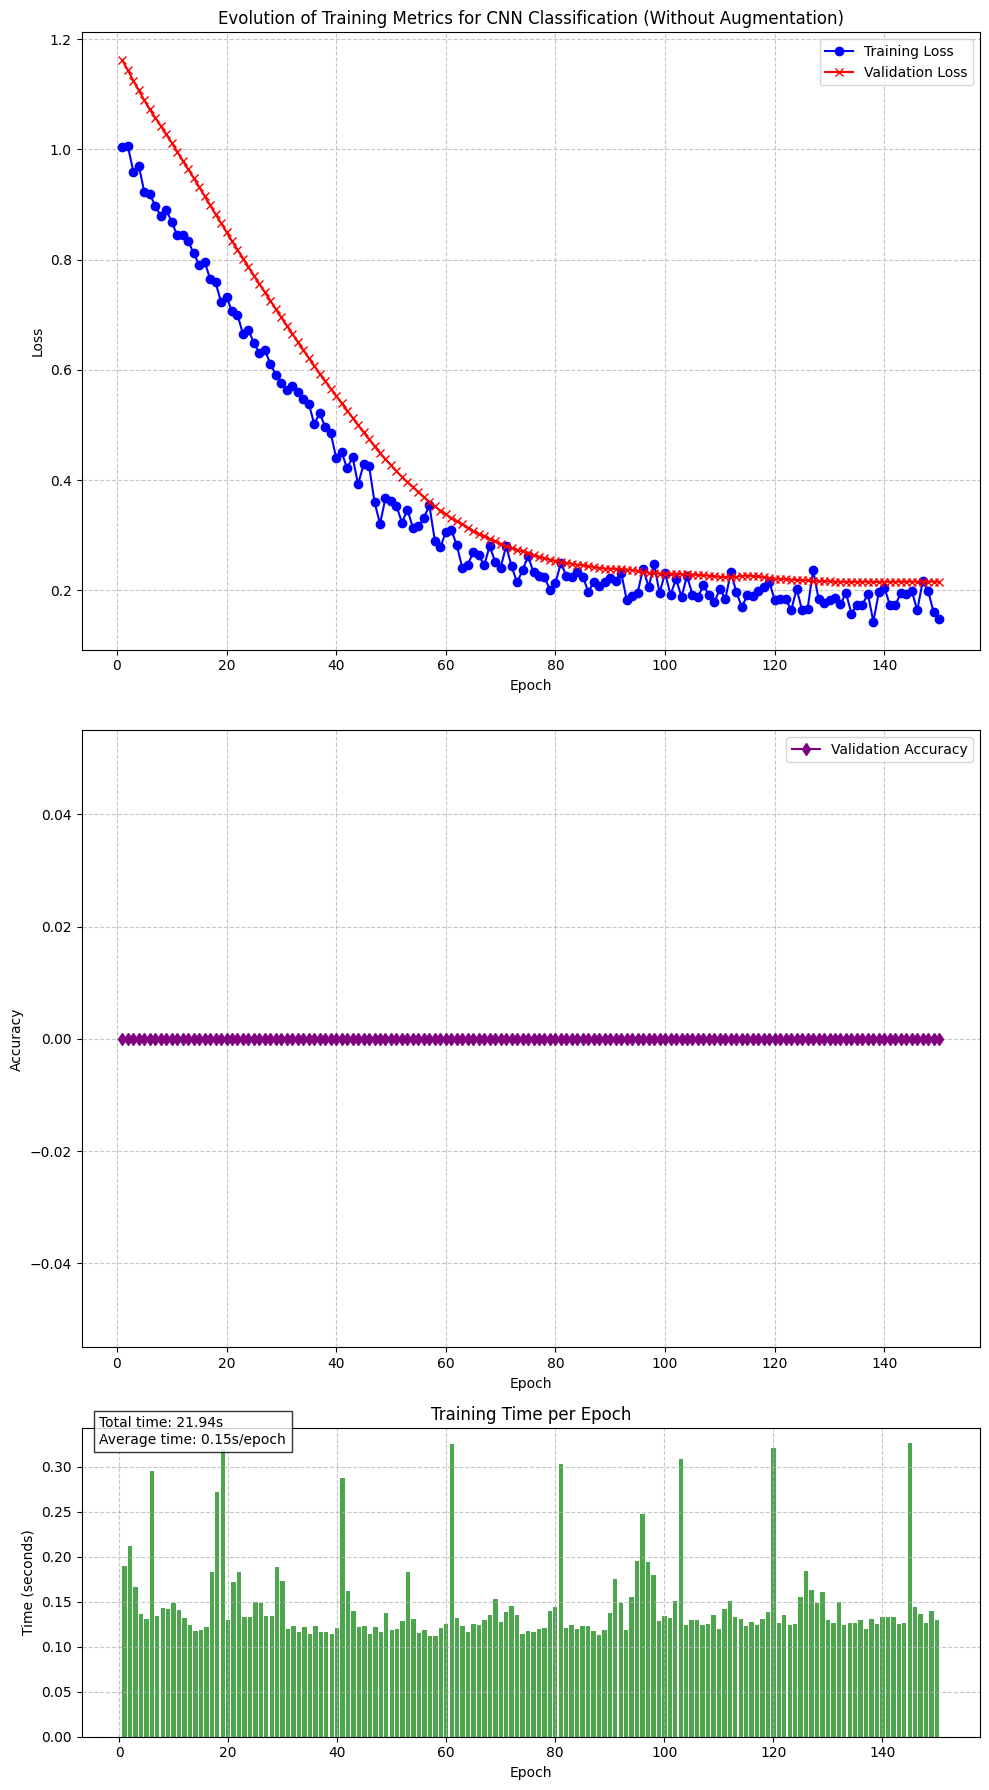

In [68]:

# Print evaluation metrics
print_classification_metrics(test_targets, test_predictions, "test")

# Visualize the evolution of metrics
plot_classification_metrics_sequence(
    metrics_history,
    title="Evolution of Training Metrics for CNN Classification (Without Augmentation)")

#### Data augmentation

##### Data preparation

In [ ]:


# Re-use the same train-test-validation split
train_data = data_3cl.iloc[indices_train].copy()
val_data = data_3cl.iloc[indices_val].copy()
test_data = data_3cl.iloc[indices_test].copy()

# Create augmentation parameters
augmentation_params = AugmentationParams(
    mixup_alpha=0.4,  # Higher alpha for more diverse mixing
    gaussian_noise_std=0.03,  # Increased noise for better robustness
    jitter_factor=0.04,  # More intensity variation
    augmentation_probability=0.8,  # Higher probability of applying augmentation
    by=["symptom", "variety", "plotLocation"],  # Group by these columns
    batch_size=100,  # Generate 100 samples per group
    exclude_columns=None,  # Don't exclude any columns to keep all spectral data
)

# Create augmenter and augment training data
augmenter = DataAugmenter(augmentation_params)
train_data_augmented = augmenter.augment(train_data)

print(f"Training set (original): {len(train_data)} samples")
print(f"Training set (after augmentation): {len(train_data_augmented)} samples")
print(f"Validation set: {len(val_data)} samples")
print(f"Test set: {len(test_data)} samples")

# Prepare original spectral features (augmented)
X_train_original = np.array(train_data_augmented[spectral_cols])
X_val_original = np.array(val_data[spectral_cols])
X_test_original = np.array(test_data[spectral_cols])

# Get target variables (num_classe values - augmented)
y_train_reg = label_encoder.transform(train_data_augmented["num_classe"])
y_val_reg = label_encoder.transform(val_data["num_classe"])
y_test_reg = label_encoder.transform(test_data["num_classe"])

# We need to re-apply transformations on the augmented data
# First, get the transformers from dataLoading module
from scripts.dataLoading import (
    snv_transformer,
    sg_smoother,
    derivative1,
    derivative2,
)

# Apply transformations on augmented data
# SNV + SG transformation
X_train_snv_sg = sg_smoother.transform(snv_transformer.transform(X_train_original))
# First derivative transformation
X_train_deriv1 = derivative1.transform(X_train_original)
# Second derivative transformation
X_train_deriv2 = derivative2.transform(X_train_original)

# For validation and test, we keep the existing transformed data
X_val_snv_sg = np.array(mat_snv_sg_3cl.iloc[indices_val][spectral_cols])
X_test_snv_sg = np.array(mat_snv_sg_3cl.iloc[indices_test][spectral_cols])

X_val_deriv1 = np.array(mat_deriv1_3cl.iloc[indices_val][spectral_cols])
X_test_deriv1 = np.array(mat_deriv1_3cl.iloc[indices_test][spectral_cols])

X_val_deriv2 = np.array(mat_deriv2_3cl.iloc[indices_val][spectral_cols])
X_test_deriv2 = np.array(mat_deriv2_3cl.iloc[indices_test][spectral_cols])

# Standardize each spectral dataset
scaler_original_aug = StandardScaler()
scaler_snv_sg_aug = StandardScaler()
scaler_deriv1_aug = StandardScaler()
scaler_deriv2_aug = StandardScaler()
scaler_y_Chl_aug = StandardScaler()

# Scale original spectral data
X_train_original = scaler_original_aug.fit_transform(X_train_original)
X_val_original = scaler_original_aug.transform(X_val_original)
X_test_original = scaler_original_aug.transform(X_test_original)

# Scale SNV+SG transformed data
X_train_snv_sg = scaler_snv_sg_aug.fit_transform(X_train_snv_sg)
X_val_snv_sg = scaler_snv_sg_aug.transform(X_val_snv_sg)
X_test_snv_sg = scaler_snv_sg_aug.transform(X_test_snv_sg)

# Scale first derivative transformed data
X_train_deriv1 = scaler_deriv1_aug.fit_transform(X_train_deriv1)
X_val_deriv1 = scaler_deriv1_aug.transform(X_val_deriv1)
X_test_deriv1 = scaler_deriv1_aug.transform(X_test_deriv1)

# Scale second derivative transformed data
X_train_deriv2 = scaler_deriv2_aug.fit_transform(X_train_deriv2)
X_val_deriv2 = scaler_deriv2_aug.transform(X_val_deriv2)
X_test_deriv2 = scaler_deriv2_aug.transform(X_test_deriv2)

# Scale target variables
y_train_chl = scaler_y_Chl_aug.fit_transform(y_train_reg)
y_val_chl = scaler_y_Chl_aug.transform(y_val_reg)
y_test_chl = scaler_y_Chl_aug.transform(y_test_reg)

# Create datasets and loaders for training and validation
train_dataset = MultiSpectralDataset(
    X_train_original, X_train_snv_sg, X_train_deriv1, X_train_deriv2, y_train_chl
)
val_dataset = MultiSpectralDataset(
    X_val_original, X_val_snv_sg, X_val_deriv1, X_val_deriv2, y_val_chl
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


##### Main loop

In [ ]:

# Initialize model, loss function and optimizer
model_aug = MultiInputCNNModel(input_dim=len(spectral_cols))
criterion = nn.MSELoss()
optimizer = optim.Adam(model_aug.parameters(), lr=LEARNING_RATE)

# Training loop
best_val_loss = float("inf")
best_model_state = None

# List to store training metrics
metrics_history: List[TrainingMetrics] = []

print(
    "Starting CNN training for regression with preprocessing and data augmentation..."
)
total_training_start = time.time()
for epoch in range(N_EPOCHS):
    epoch_start = time.time()
    # Set model to training mode
    model_aug.train()
    # Initialize the total training loss for this epoch
    train_loss = 0.0
    # Iterate over mini-batches of training data
    for X_batch, y_batch in train_loader:
        # Reset gradients to zero before computing new gradients
        optimizer.zero_grad()
        # Forward pass: compute model predictions
        outputs = model_aug(X_batch)
        # Compute the loss between predictions and true values
        loss = criterion(outputs, y_batch)
        # Backward pass: compute gradients of the loss
        loss.backward()
        # Update model parameters using the optimizer
        optimizer.step()
        # Accumulate the batch loss
        train_loss += loss.item()

    # Validation phase
    model_aug.eval()
    # Initialize the total validation loss for this epoch
    val_loss = 0.0
    # Disable gradient computation for validation
    with torch.no_grad():
        # Iterate over mini-batches of validation data
        for X_batch, y_batch in val_loader:
            # Forward pass only
            outputs = model_aug(X_batch)
            # Compute and accumulate the validation loss
            val_loss += criterion(outputs, y_batch).item()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    # Calculate epoch execution time
    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start

    # Store metrics for each epoch
    metrics_history.append(
        TrainingMetrics(
            epoch=epoch + 1,
            train_loss=avg_train_loss,
            val_loss=avg_val_loss,
            epoch_time=epoch_time,
        )
    )

    # Keep track of the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model_aug.state_dict().copy()

    # Print metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{N_EPOCHS}]")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Epoch Time: {epoch_time:.2f}s")
        print("-" * 50)

total_training_end = time.time()
total_training_time = total_training_end - total_training_start
print(f"Total training time: {total_training_time:.2f} seconds")
print(f"Average time per epoch: {total_training_time/N_EPOCHS:.2f} seconds")

# Load the best model
if best_model_state is not None:
    model_aug.load_state_dict(best_model_state)
    print(
        f"Best model loaded with validation loss of {best_val_loss/len(val_loader):.4f}"
    )

# Evaluation on test set
model_aug.eval()
with torch.no_grad():
    # Create dataset for test data
    test_inputs = [
        torch.FloatTensor(X_test_original).unsqueeze(1),
        torch.FloatTensor(X_test_snv_sg).unsqueeze(1),
        torch.FloatTensor(X_test_deriv1).unsqueeze(1),
        torch.FloatTensor(X_test_deriv2).unsqueeze(1),
    ]
    test_targets = torch.FloatTensor(y_test_chl)

    # Get predictions for all test data at once
    test_predictions = model_aug(test_inputs).detach().numpy()
    test_targets = test_targets.detach().numpy()

# Convert predictions back to original scale
test_predictions = scaler_y_Chl_aug.inverse_transform(test_predictions)
test_targets = scaler_y_Chl_aug.inverse_transform(test_targets)

# Print evaluation metrics
print_regression_metrics(test_targets, test_predictions, "test")

# Visualize the evolution of metrics
plot_training_metrics(
    metrics_history,
    title="Evolution of Training Metrics for CNN Regression (Multiple Pretreated Inputs with Augmentation)",
    save_path=str(project_root)
    + "/plots/training_metrics_cnn_pretreated_regression_augmented.png",
)

# Visualize predictions vs actual values
plt.figure(figsize=(10, 8))
plt.scatter(test_targets, test_predictions, alpha=0.6)
plt.plot(
    [np.min(test_targets), np.max(test_targets)],
    [np.min(test_targets), np.max(test_targets)],
    "r--",
)
plt.xlabel("Actual Chl Values")
plt.ylabel("Predicted Chl Values")
plt.title(
    f"CNN Regression with Multiple Pretreated Inputs and Augmentation: Predictions vs Actual Values\nR² = {r2_score(test_targets, test_predictions):.4f}"
)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


#### Comparaison

In [ ]:

# Compare the two models by evaluating both on the test set
model.eval()
model_aug.eval()

with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test_cls).unsqueeze(1)

    # Get predictions from both models
    test_logits_standard = model(X_test_tensor)
    test_logits_augmented = model_aug(X_test_tensor)

    test_pred_standard = torch.argmax(test_logits_standard, dim=1).detach().numpy()
    test_pred_augmented = torch.argmax(test_logits_augmented, dim=1).detach().numpy()

# Calculate metrics for both models
accuracy_standard = accuracy_score(test_targets, test_pred_standard)
accuracy_augmented = accuracy_score(test_targets, test_pred_augmented)

precision_standard = precision_score(test_targets, test_pred_standard, average="macro")
precision_augmented = precision_score(
    test_targets, test_pred_augmented, average="macro"
)

recall_standard = recall_score(test_targets, test_pred_standard, average="macro")
recall_augmented = recall_score(test_targets, test_pred_augmented, average="macro")

f1_standard = f1_score(test_targets, test_pred_standard, average="macro")
f1_augmented = f1_score(test_targets, test_pred_augmented, average="macro")

# Print comparison
print(f"Accuracy (standard): {accuracy_standard:.4f}")
print(f"Accuracy (augmented): {accuracy_augmented:.4f}")
print(
    f"Improvement: {(accuracy_augmented - accuracy_standard) / accuracy_standard * 100:.2f}%"
)
print()

print(f"Precision (standard): {precision_standard:.4f}")
print(f"Precision (augmented): {precision_augmented:.4f}")
print(
    f"Improvement: {(precision_augmented - precision_standard) / precision_standard * 100:.2f}%"
)
print()

print(f"Recall (standard): {recall_standard:.4f}")
print(f"Recall (augmented): {recall_augmented:.4f}")
print(
    f"Improvement: {(recall_augmented - recall_standard) / recall_standard * 100:.2f}%"
)
print()

print(f"F1 Score (standard): {f1_standard:.4f}")
print(f"F1 Score (augmented): {f1_augmented:.4f}")
print(f"Improvement: {(f1_augmented - f1_standard) / f1_standard * 100:.2f}%")

# Print classification reports for both models
print("\nClassification Report (Standard Model):")
cls_report_standard = classification_report(test_targets, test_pred_standard, digits=4)
print(cls_report_standard)

print("\nClassification Report (Augmented Model):")
cls_report_augmented = classification_report(
    test_targets, test_pred_augmented, digits=4
)
print(cls_report_augmented)

# Visualize confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot confusion matrix for standard model
cm_standard = confusion_matrix(test_targets, test_pred_standard)
sns.heatmap(cm_standard, annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title(f"Standard Model\nAccuracy: {accuracy_standard:.4f}")
ax1.set_ylabel("True Label")
ax1.set_xlabel("Predicted Label")

# Plot confusion matrix for augmented model
cm_augmented = confusion_matrix(test_targets, test_pred_augmented)
sns.heatmap(cm_augmented, annot=True, fmt="d", cmap="Blues", ax=ax2)
ax2.set_title(f"Augmented Model\nAccuracy: {accuracy_augmented:.4f}")
ax2.set_ylabel("True Label")
ax2.set_xlabel("Predicted Label")

plt.tight_layout()
plt.show()
